# **Q11. Scaler - Clustering**

## **Problem Statement:**
### 1. Help OLA to cluster learners on the basis of their job profile, company, and other features.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import statsmodels.api as sm
import pylab
import missingno as msno
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

In [2]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
string_types = ['string']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]

In [3]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<10:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<10:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

        H = sum(ujd) / (sum(ujd) + sum(wjd))
        if isnan(H):
            H = 0
    return H

In [5]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [6]:
filename = 'scaler_clustering.csv'
df = pd.read_csv(filename)
df = convert_to_best_type(df)

***
***
## **1. Analyzing Basic Metrics.**

In [7]:
df.head()

Unnamed: 0               company_hash  \
0           0             atrgxnnt xzaxv   
1           1  qtrxvzwt xzegwgbb rxbxnta   
2           2              ojzwnvwnxw vx   
3           3                  ngpgutaxv   
4           4                 qxen sqghu   

                                          email_hash  orgyear      ctc  \
0  6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...   2016.0  1100000   
1  b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...   2018.0   449999   
2  4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...   2015.0  2000000   
3  effdede7a2e7c2af664c8a31d9346385016128d66bbc58...   2017.0   700000   
4  6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...   2017.0  1400000   

         job_position  ctc_updated_year  
0               Other            2020.0  
1  FullStack Engineer            2019.0  
2    Backend Engineer            2020.0  
3    Backend Engineer            2019.0  
4  FullStack Engineer            2019.0

In [8]:
df = df[df.columns[1:]]
print("Shape:", df.shape, "\n")

Shape: (205843, 6) 



In [9]:
df.dtypes

company_hash         string
email_hash           string
orgyear             float64
ctc                   int64
job_position         string
ctc_updated_year    float64
dtype: object

***
***
## **2. Missing Value detection and treatment.**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  string 
 1   email_hash        205843 non-null  string 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153281 non-null  string 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), string(3)
memory usage: 9.4 MB


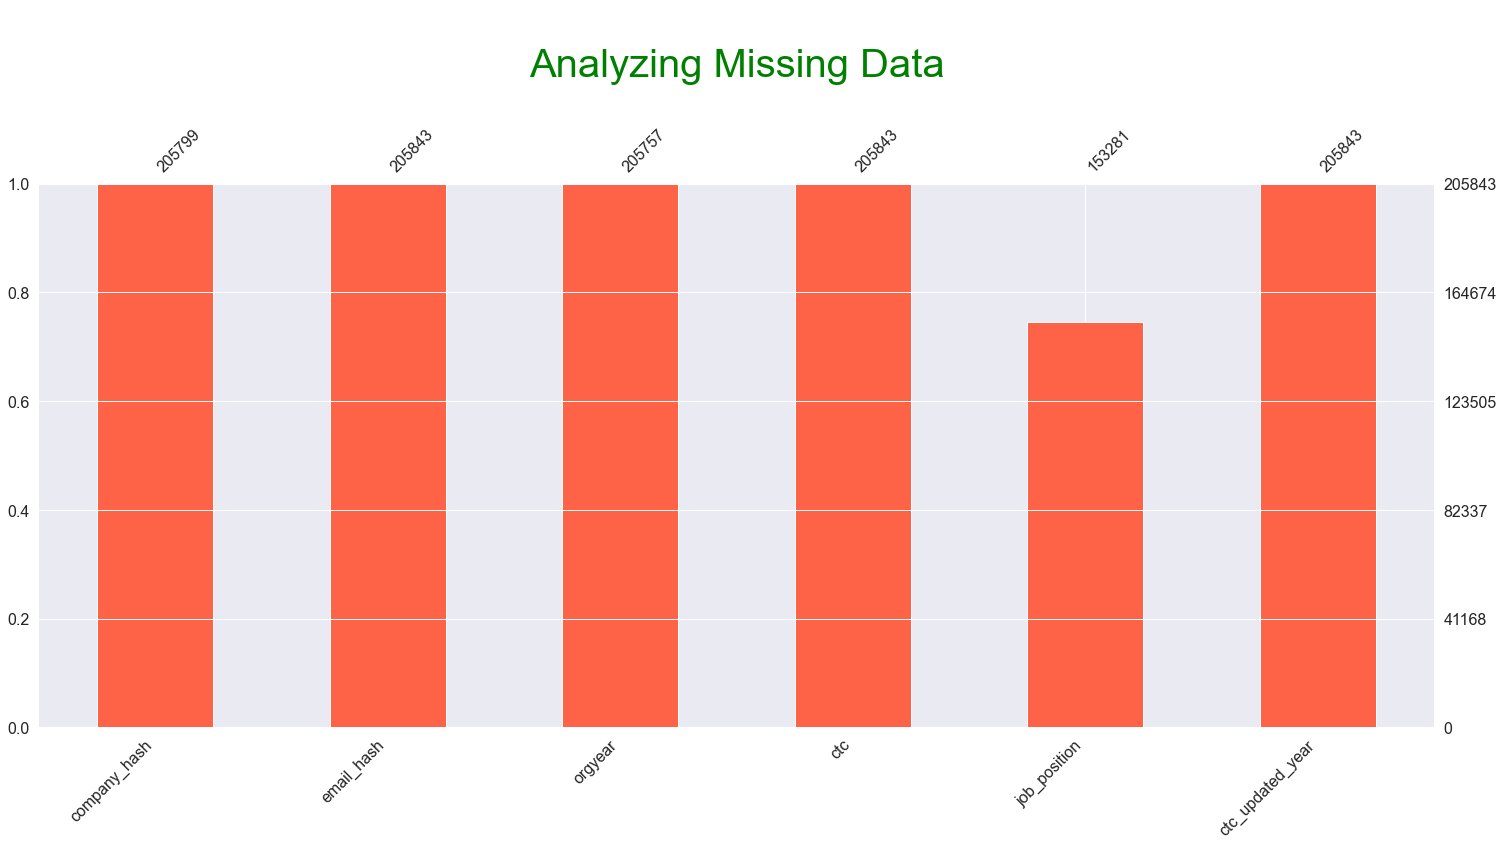

In [11]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

In [12]:
df.nunique()

company_hash         37299
email_hash          153443
orgyear                 77
ctc                   3360
job_position          1017
ctc_updated_year         7
dtype: int64

In [13]:
df[df['job_position'].isna()].head()

company_hash  \
8           utqoxontzn ojontbo   
9                        xrbhd   
12  mvqwrvjo wgqugqvnt mvzpxzs   
17                        puxn   
18               mvlvl exzotqc   

                                           email_hash  orgyear      ctc  \
8   e245da546bf50eba09cb7c9976926bd56557d1ac9a17fb...   2020.0   450000   
9   b2dc928f4c22a9860b4a427efb8ab761e1ce0015fba1a5...   2019.0   360000   
12  7f24d2f5171ea469482a9966832237bc023678883ecd0c...   2020.0   800000   
17  26b502eb6439ac80bd618a6f7c2b1c640b84c1e64c472c...   2020.0  1400000   
18  62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816...   2018.0   100000   

   job_position  ctc_updated_year  
8          <NA>            2019.0  
9          <NA>            2019.0  
12         <NA>            2020.0  
17         <NA>            2019.0  
18         <NA>            2021.0

In [14]:
#df.loc[df['job_position'].isna(), 'job_position'] = 'Unknown'
df = df.loc[~df['job_position'].isna()]

In [15]:
for column in get_columns_by_types(df, string_types):
    df[column] = df[column].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', str(x)))

***
***
## **3. Outlier Detection and Treatment.**

In [16]:
df.describe()

orgyear           ctc  ctc_updated_year
count  153219.000000  1.532810e+05     153281.000000
mean     2014.446661  2.366966e+06       2019.504407
std        25.769588  1.187741e+07          1.324525
min         0.000000  2.000000e+00       2015.000000
25%      2013.000000  5.700000e+05       2019.000000
50%      2016.000000  1.000000e+06       2020.000000
75%      2018.000000  1.720000e+06       2021.000000
max      2204.000000  2.000000e+08       2021.000000

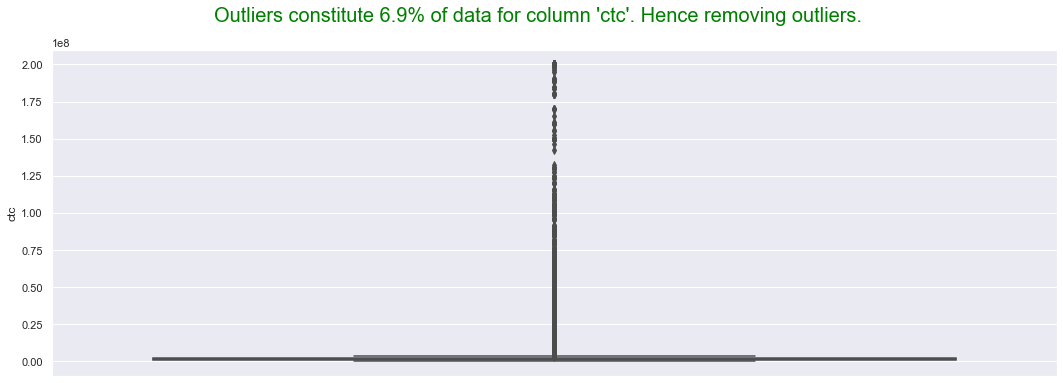

In [17]:
for column in ['ctc']:
    df = remove_outlier(df, column)

In [18]:
df = df[(df['orgyear']>1950) & (df['orgyear']<2025)]
df = df[(df['ctc_updated_year']>1950) & (df['ctc_updated_year']<2025)]

In [19]:
df.describe()

orgyear           ctc  ctc_updated_year
count  142593.000000  1.425930e+05     142593.000000
mean     2014.994551  1.107952e+06       2019.506336
std         4.024714  7.587827e+05          1.328675
min      1970.000000  2.000000e+00       2015.000000
25%      2013.000000  5.200000e+05       2019.000000
50%      2016.000000  9.000000e+05       2020.000000
75%      2018.000000  1.500000e+06       2021.000000
max      2024.000000  3.440000e+06       2021.000000

***
***
## **4. Handling Duplicate Records.**

In [20]:
dup = df['email_hash'].value_counts().index[0]
df[df['email_hash'] == dup]

company_hash                                         email_hash  \
9857       ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
10002      ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
10583      ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
12784      ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
20715      ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
138253     ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
159251     ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
165343     ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   
178749     ihvrwgbb  6842660273f70e9aa239026ba33bfe82275d6ab0d20124...   

        orgyear      ctc      job_position  ctc_updated_year  
9857     2017.0  2400000       QA Engineer            2020.0  
10002    2017.0  2400000   Devops Engineer            2020.0  
10583    2017.0  2400000  Backend Engineer            2020.0  
12784    2017.0  2400000             Other            2020.0  
20715    2017.0  2400000              SDET            2020.0  
138253   2017.0  2000000              SDET            2020.0  
159251   2017.0  2000000   Devops Engineer            2020.0  
165343   2017.0  2000000             Other            2020.0  
178749   2017.0  2000000  Backend Engineer            2020.0

In [21]:
dup = df['email_hash'].value_counts().index[1]
df[df['email_hash'] == dup]

company_hash  \
10214   wgcxvb ntwyzgrgsxto   
10734   wgcxvb ntwyzgrgsxto   
16651   wgcxvb ntwyzgrgsxto   
18165   wgcxvb ntwyzgrgsxto   
20794   wgcxvb ntwyzgrgsxto   
137990  wgcxvb ntwyzgrgsxto   
164929  wgcxvb ntwyzgrgsxto   
168354  wgcxvb ntwyzgrgsxto   
172176  wgcxvb ntwyzgrgsxto   

                                               email_hash  orgyear      ctc  \
10214   3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1130000   
10734   3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1130000   
16651   3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1130000   
18165   3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1130000   
20794   3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1130000   
137990  3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1085000   
164929  3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1085000   
168354  3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1085000   
172176  3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...   2018.0  1085000   

              job_position  ctc_updated_year  
10214   Engineering Intern            2021.0  
10734                Other            2021.0  
16651     Backend Engineer            2021.0  
18165       Data Scientist            2021.0  
20794         Data Analyst            2021.0  
137990      Data Scientist            2020.0  
164929        Data Analyst            2020.0  
168354    Backend Engineer            2020.0  
172176  Engineering Intern            2020.0

In [22]:
df = df.sort_values(by=['email_hash', 'ctc_updated_year', 'ctc', 'orgyear'], ascending=[True, False, False, False])

In [23]:
df=df.groupby(['email_hash']).agg({'company_hash':'first',
                                  'orgyear':'min',
                                  'ctc':'first',
                                  'ctc_updated_year':'first',
                                  'job_position':'first'}).reset_index()

In [24]:
df = df.dropna()

In [25]:
df.head()

email_hash  \
0  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
1  0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...   
3  0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...   

                company_hash  orgyear      ctc  ctc_updated_year  \
0               nqsn axsxnvr   2013.0   250000            2020.0   
1                      gunhb   2021.0  1300000            2019.0   
2      bxwqgotbx wgqugqvnxgz   2004.0  2000000            2021.0   
3  nvnv wgzohrnvzwj otqcxwto   2018.0   450000            2021.0   
4                  vqtkkgopj   2016.0   750000            2020.0   

             job_position  
0        Backend Engineer  
1      FullStack Engineer  
2      FullStack Engineer  
3  Database Administrator  
4       Frontend Engineer

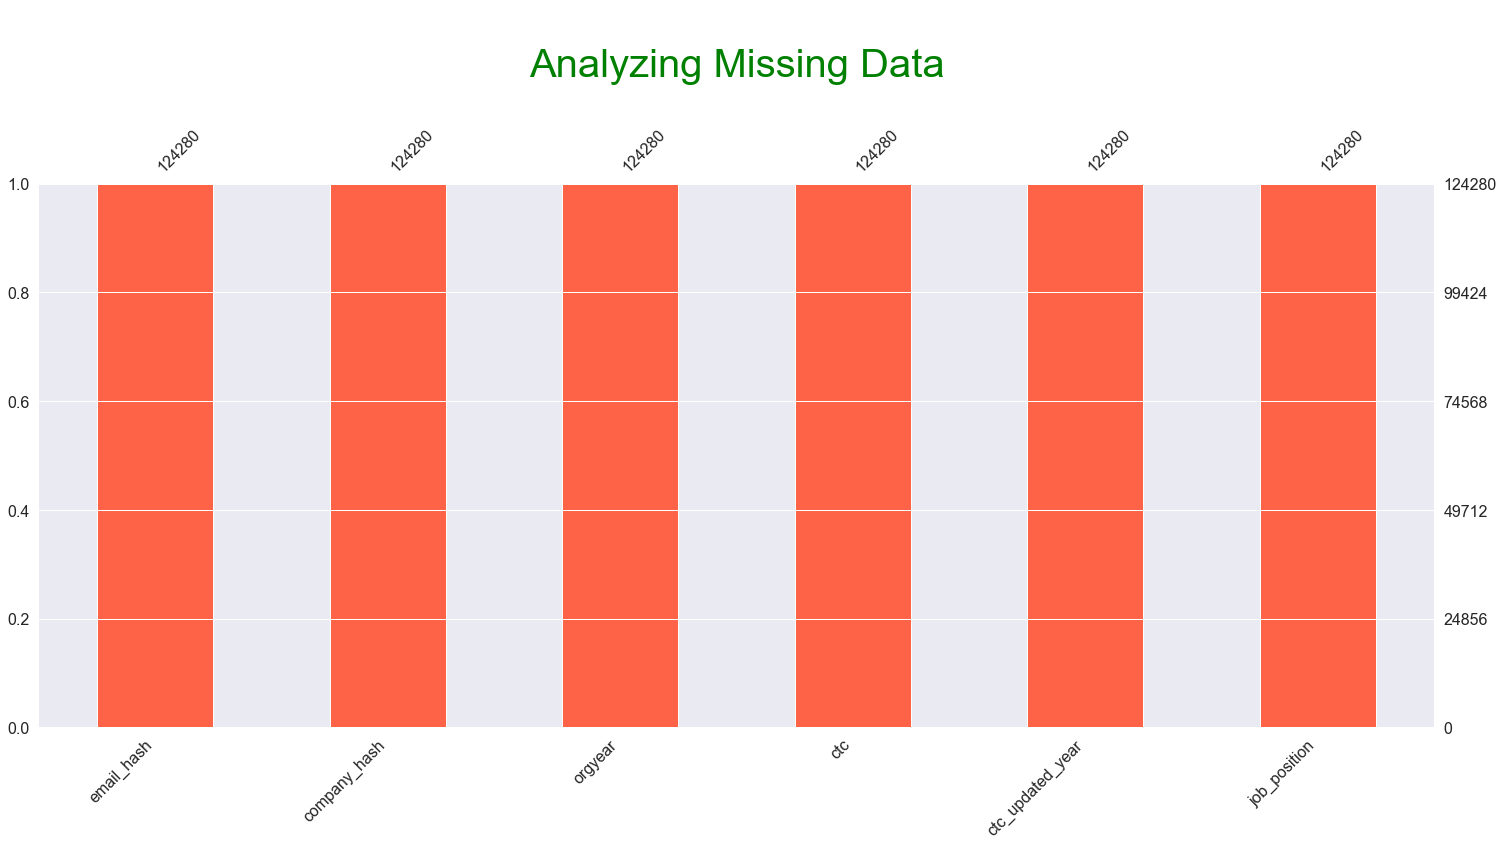

In [26]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

In [27]:
df.nunique()

email_hash          124280
company_hash         31952
orgyear                 49
ctc                   2230
ctc_updated_year         7
job_position           766
dtype: int64

***
***
## **5. Feature Engineering - Creating New Features.**

In [28]:
df['yoe'] = 2023 - df['orgyear']

In [29]:
company_averages = df.groupby(['company_hash'])['ctc'].agg(['median']).reset_index()
job_position_averages = df.groupby(['job_position'])['ctc'].agg(['median']).reset_index()
company_department_averages = df.groupby(['company_hash', 'job_position'])['ctc'].agg(['median']).reset_index()
yoe_averages = df.groupby(['yoe'])['ctc'].agg(['median']).reset_index()
company_yoe_averages = df.groupby(['company_hash', 'yoe'])['ctc'].agg(['median']).reset_index()
job_position_yoe_averages = df.groupby(['job_position', 'yoe'])['ctc'].agg(['median']).reset_index()

In [30]:
df = df.merge(company_averages, on='company_hash')
df.rename(columns = {'median':'company_avg'}, inplace = True)
df = df.merge(job_position_averages, on='job_position')
df.rename(columns = {'median':'job_position_avg'}, inplace = True)
df = df.merge(yoe_averages, on='yoe')
df.rename(columns = {'median':'yoe_avg'}, inplace = True)
df = df.merge(company_department_averages, on=['company_hash', 'job_position'])
df.rename(columns = {'median':'company_department_avg'}, inplace = True)
df = df.merge(company_yoe_averages, on=['company_hash', 'yoe'])
df.rename(columns = {'median':'company_yoe_avg'}, inplace = True)
df = df.merge(job_position_yoe_averages, on=['job_position', 'yoe'])
df.rename(columns = {'median':'job_position_yoe_avg'}, inplace = True)

In [31]:
df.head()

email_hash  \
0  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
1  3e3b5b1152033db04deabf6d1e10b5e48bbc87ee112a7d...   
2  8fe63f3fb51224450ca6590dac3c8f60bf01d8823f6770...   
3  b71bffcdc39f13604559ce460d3fbaf7cef21e671ea94e...   
4  0f997b4eca69c18f4d37b0dcb4f02732d747ff3febbef5...   

                company_hash  orgyear      ctc  ctc_updated_year  \
0               nqsn axsxnvr   2013.0   250000            2020.0   
1                      gunhb   2013.0  1550000            2020.0   
2                      gunhb   2013.0   600000            2017.0   
3      bxwqgotbx wgqugqvnxgz   2013.0  2000000            2019.0   
4  nvnv wgzohrnvzwj otqcxwto   2013.0   700000            2021.0   

       job_position   yoe  company_avg  job_position_avg    yoe_avg  \
0  Backend Engineer  10.0     250000.0         1120000.0  1095000.0   
1  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
2  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
3  Backend Engineer  10.0    1625000.0         1120000.0  1095000.0   
4  Backend Engineer  10.0     455000.0         1120000.0  1095000.0   

   company_department_avg  company_yoe_avg  job_position_yoe_avg  
0                250000.0         250000.0             1400000.0  
1               1265000.0        1350000.0             1400000.0  
2               1265000.0        1350000.0             1400000.0  
3               2000000.0        2000000.0             1400000.0  
4                476500.0         700000.0             1400000.0

In [32]:
df['company_class'] = 2
df.loc[df['ctc']>df['company_avg']*1.2, 'company_class'] = 1
df.loc[df['ctc']<df['company_avg']*0.8, 'company_class'] = 3

In [33]:
df['company_dept_class'] = 2
df.loc[df['ctc']>df['company_department_avg']*1.2, 'company_dept_class'] = 1
df.loc[df['ctc']<df['company_department_avg']*0.8, 'company_dept_class'] = 3

In [34]:
df['company_yoe_class'] = 2
df.loc[df['ctc']>df['company_yoe_avg']*1.2, 'company_yoe_class'] = 1
df.loc[df['ctc']<df['company_yoe_avg']*0.8, 'company_yoe_class'] = 3

In [35]:
df['yoe_tier'] = 2
df.loc[df['ctc']>df['yoe_avg']*1.2, 'yoe_tier'] = 1
df.loc[df['ctc']<df['yoe_avg']*0.8, 'yoe_tier'] = 3

In [36]:
df['job_position_tier'] = 2
df.loc[df['ctc']>df['job_position_avg']*1.2, 'job_position_tier'] = 1
df.loc[df['ctc']<df['job_position_avg']*0.8, 'job_position_tier'] = 3

In [37]:
df['yoe_job_position_tier'] = 2
df.loc[df['ctc']>df['job_position_yoe_avg']*1.2, 'yoe_job_position_tier'] = 1
df.loc[df['ctc']<df['job_position_yoe_avg']*0.8, 'yoe_job_position_tier'] = 3

In [38]:
df = convert_to_best_type(df)

In [39]:
df.head()

email_hash  \
0  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
1  3e3b5b1152033db04deabf6d1e10b5e48bbc87ee112a7d...   
2  8fe63f3fb51224450ca6590dac3c8f60bf01d8823f6770...   
3  b71bffcdc39f13604559ce460d3fbaf7cef21e671ea94e...   
4  0f997b4eca69c18f4d37b0dcb4f02732d747ff3febbef5...   

                company_hash  orgyear      ctc  ctc_updated_year  \
0               nqsn axsxnvr   2013.0   250000            2020.0   
1                      gunhb   2013.0  1550000            2020.0   
2                      gunhb   2013.0   600000            2017.0   
3      bxwqgotbx wgqugqvnxgz   2013.0  2000000            2019.0   
4  nvnv wgzohrnvzwj otqcxwto   2013.0   700000            2021.0   

       job_position   yoe  company_avg  job_position_avg    yoe_avg  \
0  Backend Engineer  10.0     250000.0         1120000.0  1095000.0   
1  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
2  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
3  Backend Engineer  10.0    1625000.0         1120000.0  1095000.0   
4  Backend Engineer  10.0     455000.0         1120000.0  1095000.0   

   company_department_avg  company_yoe_avg  job_position_yoe_avg  \
0                250000.0         250000.0             1400000.0   
1               1265000.0        1350000.0             1400000.0   
2               1265000.0        1350000.0             1400000.0   
3               2000000.0        2000000.0             1400000.0   
4                476500.0         700000.0             1400000.0   

  company_class company_dept_class company_yoe_class yoe_tier  \
0             2                  2                 2        3   
1             1                  1                 2        1   
2             3                  3                 3        3   
3             1                  2                 2        1   
4             1                  1                 2        3   

  job_position_tier yoe_job_position_tier  
0                 3                     3  
1                 1                     2  
2                 3                     3  
3                 1                     1  
4                 3                     3

***
***
## **6. Univariate Analysis - Categorical Features.**

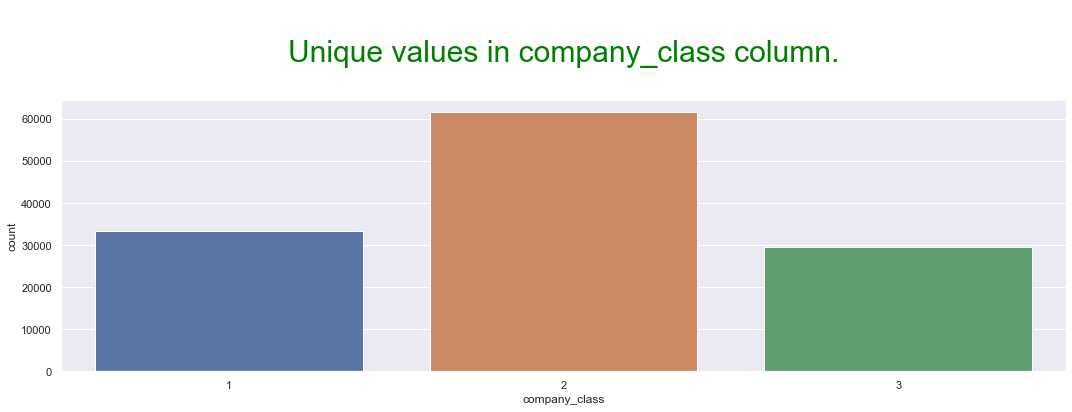

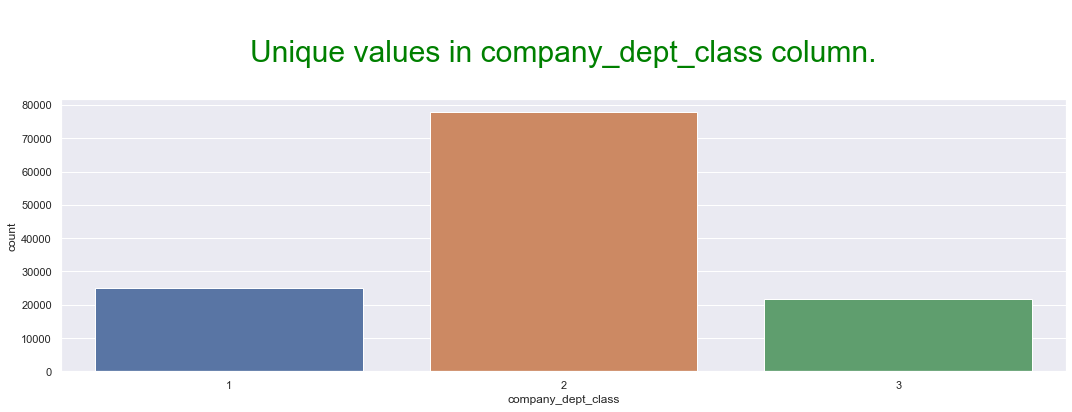

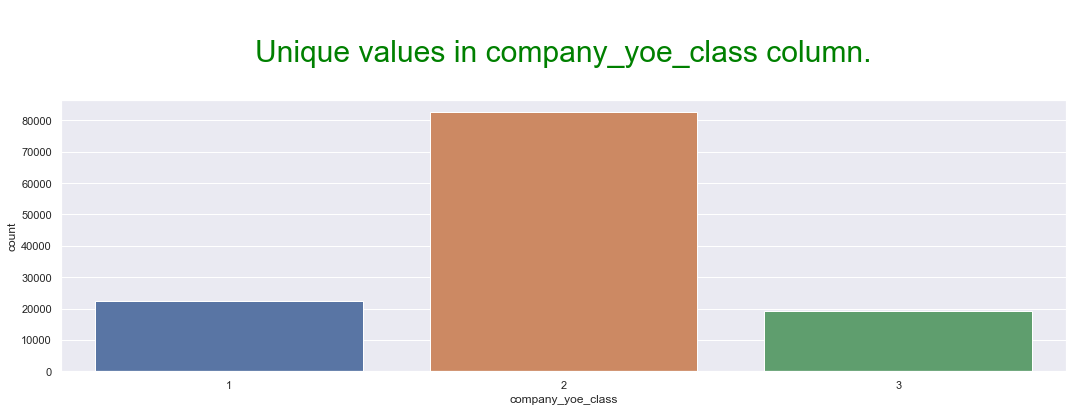

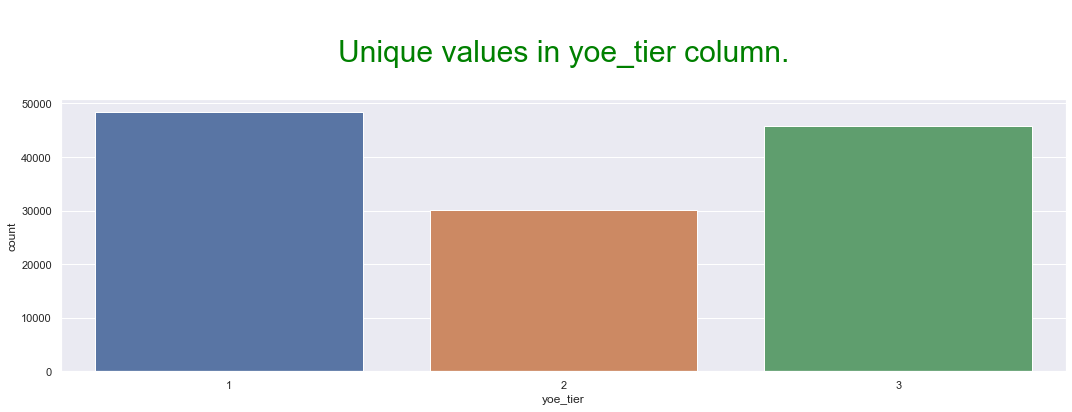

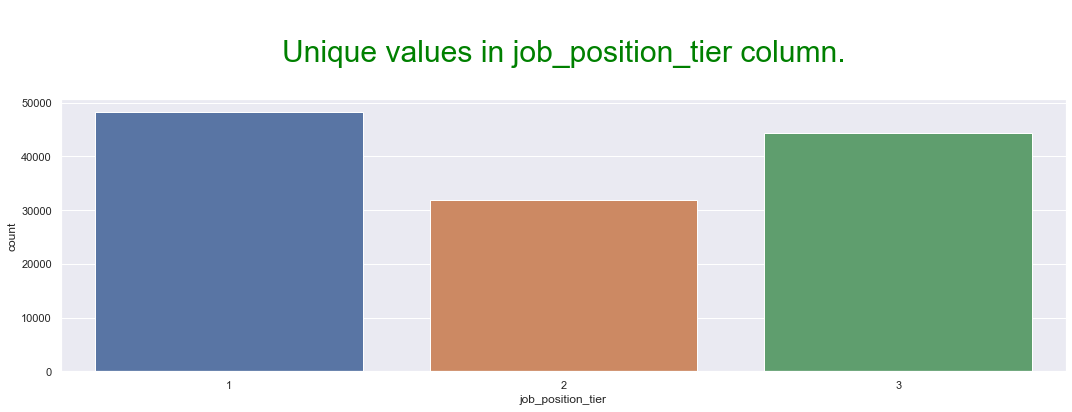

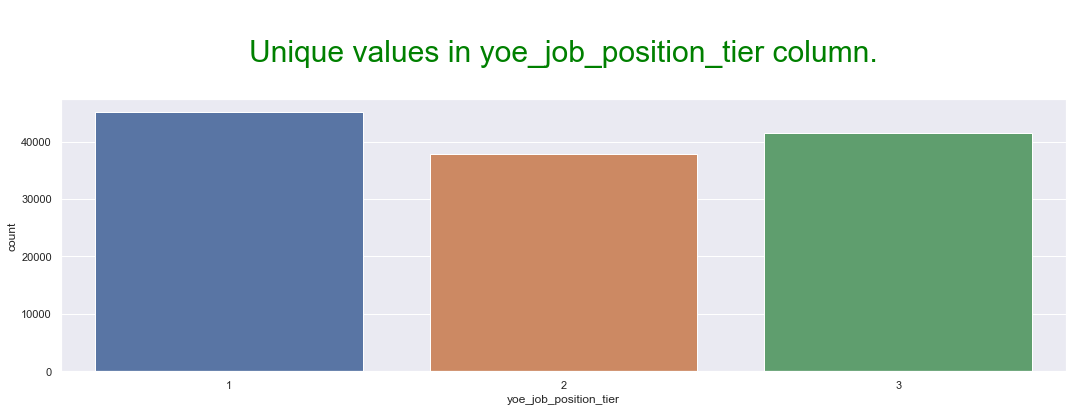

In [41]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **7. Univariate Analysis - Discrete Features.**

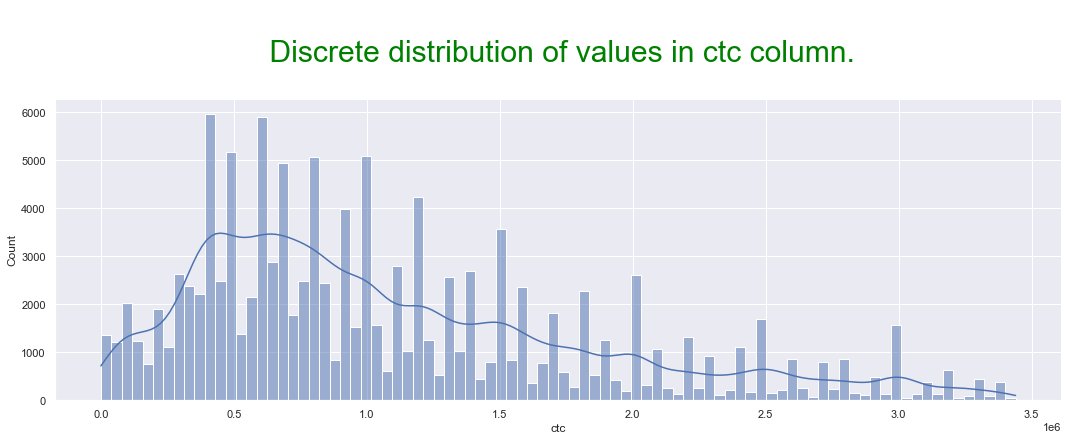

In [42]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **8. Univariate Analysis - Continuous Features.**

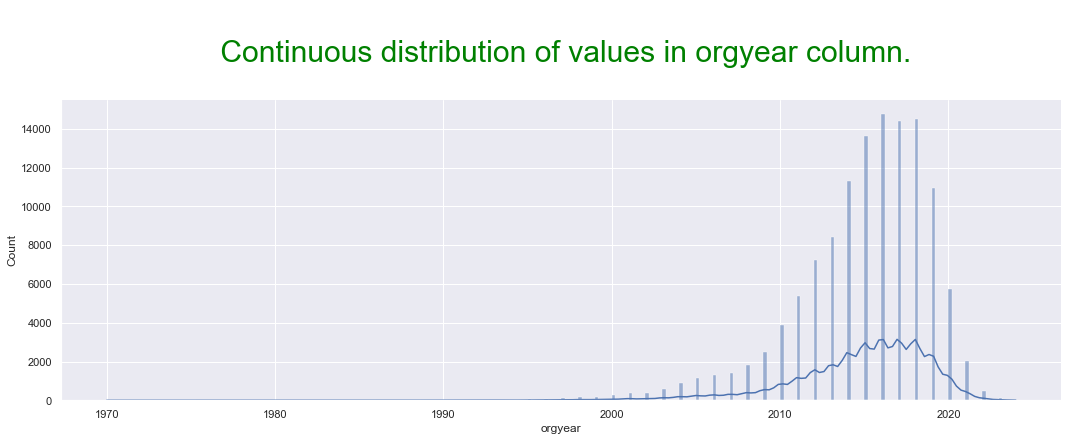

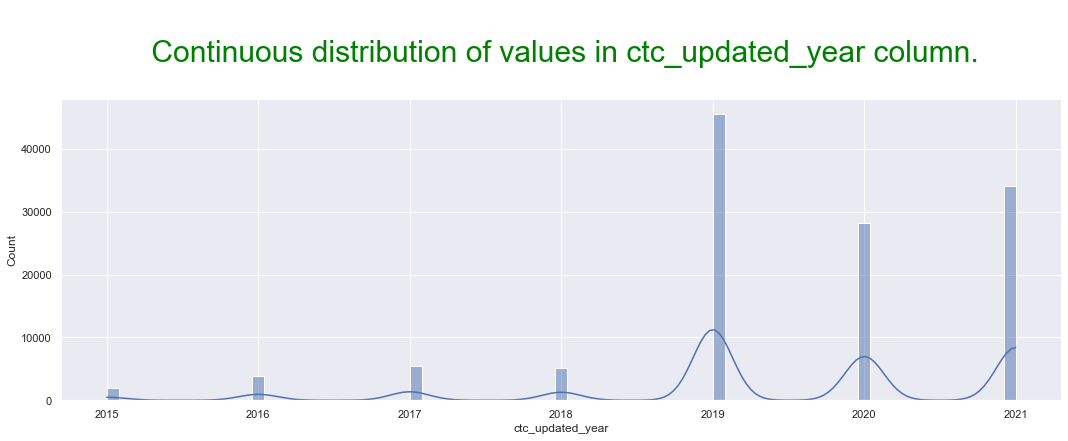

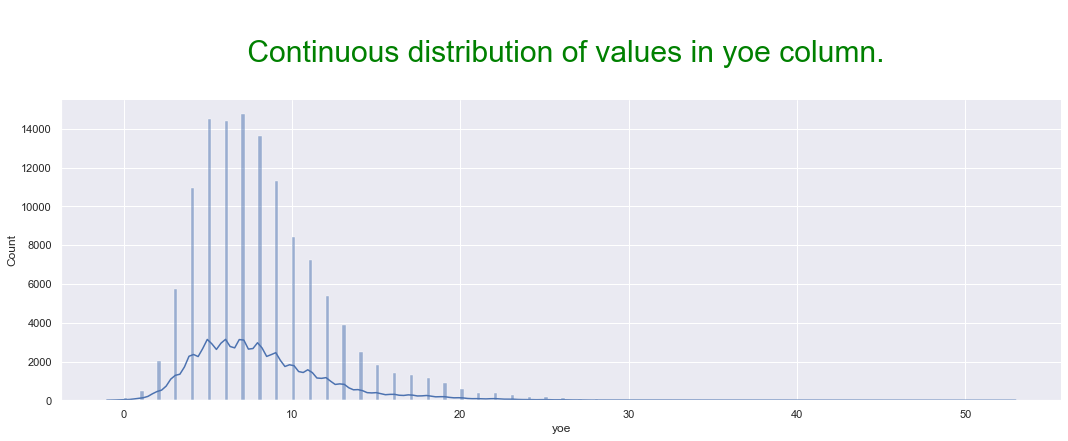

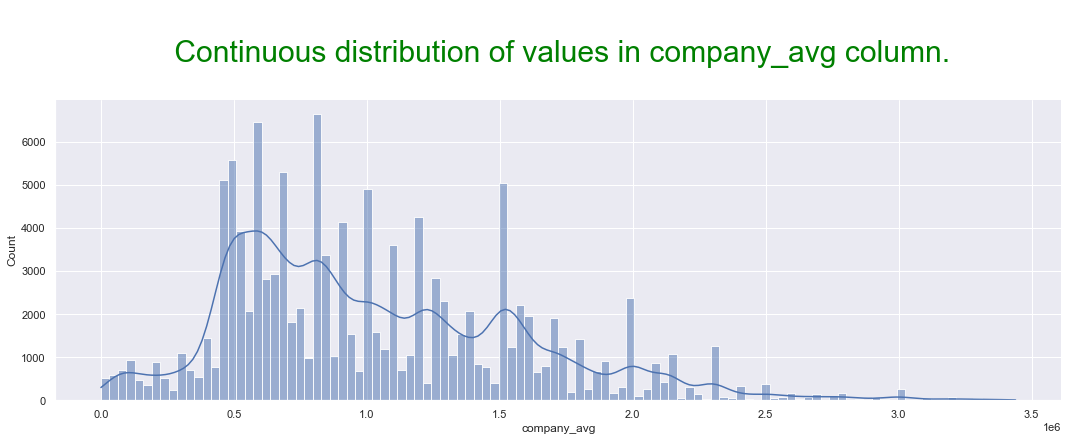

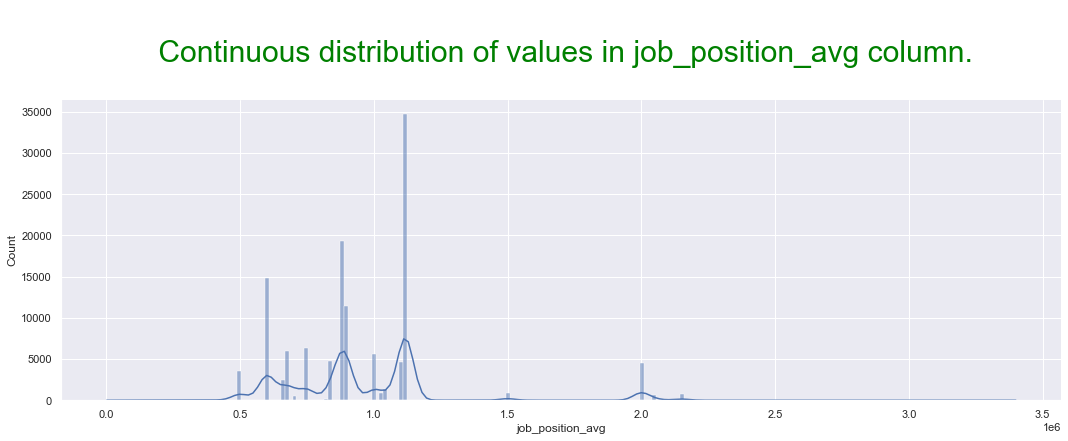

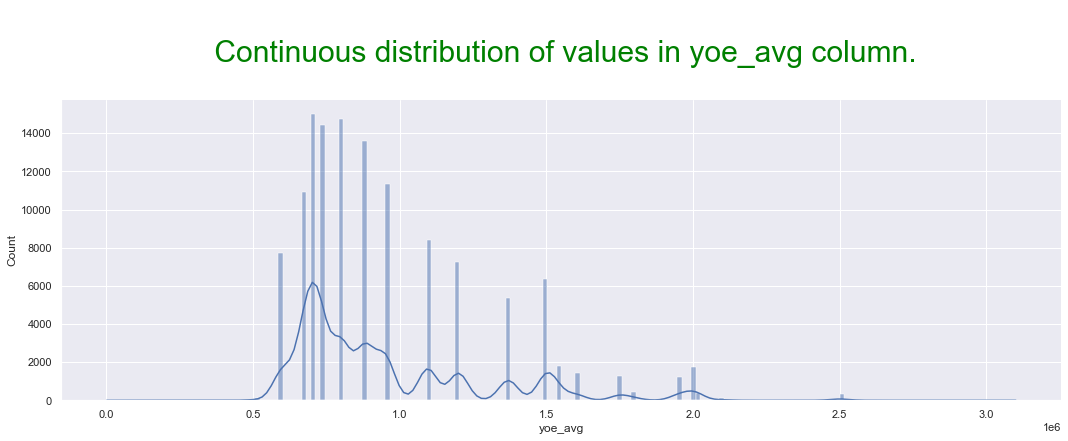

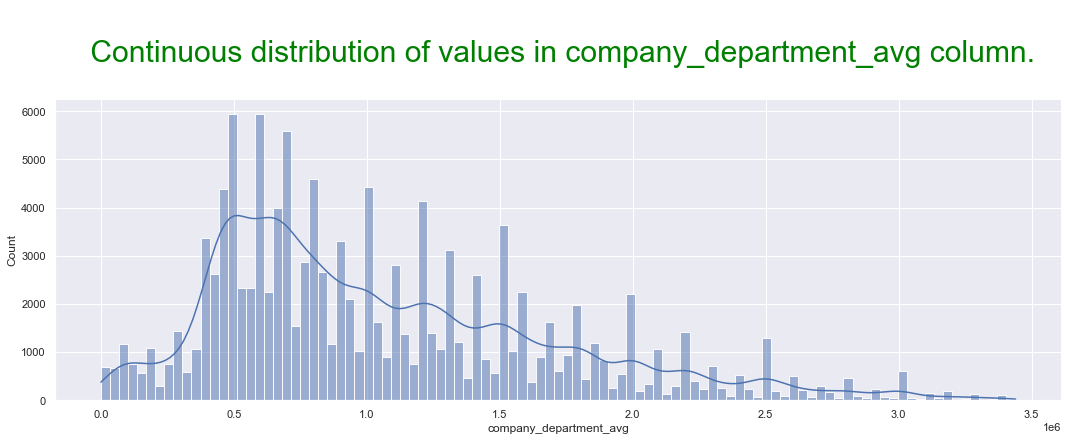

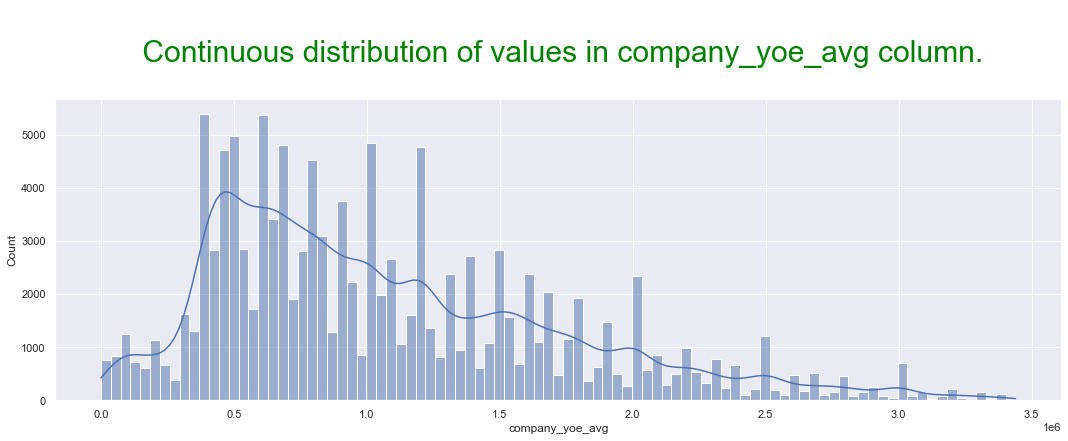

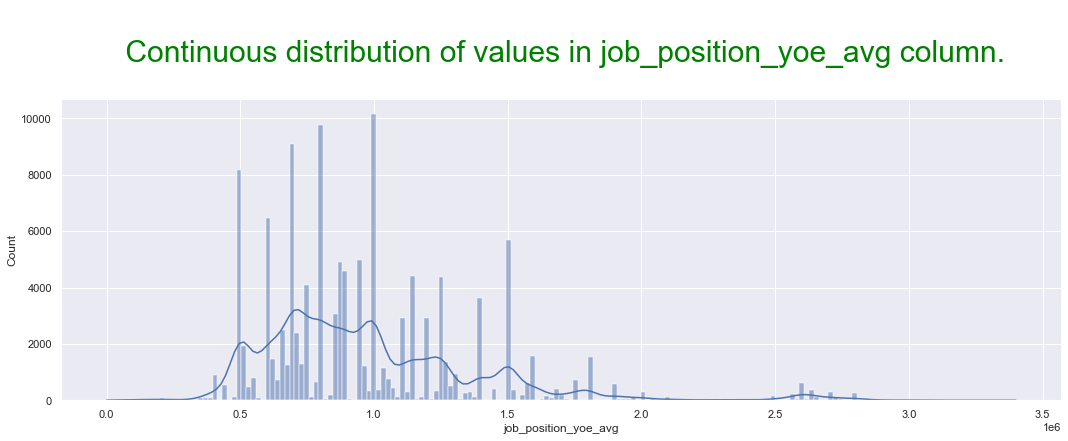

In [43]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **9. Bivariate Analysis.**

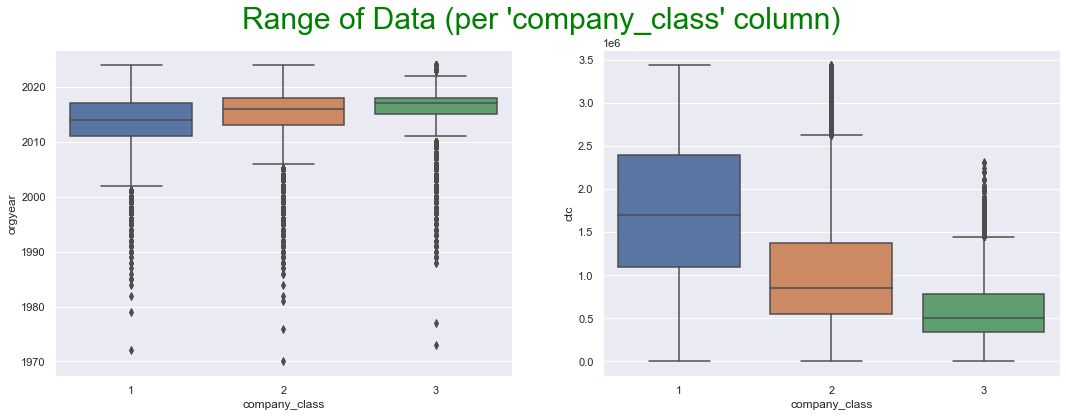

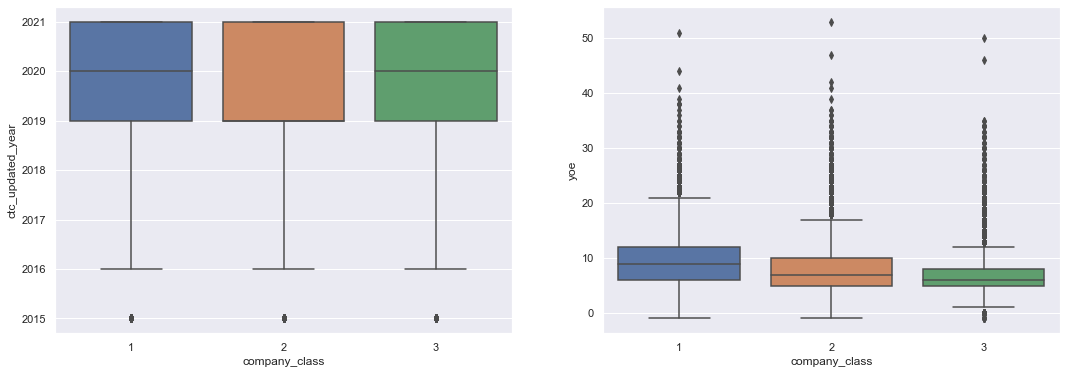

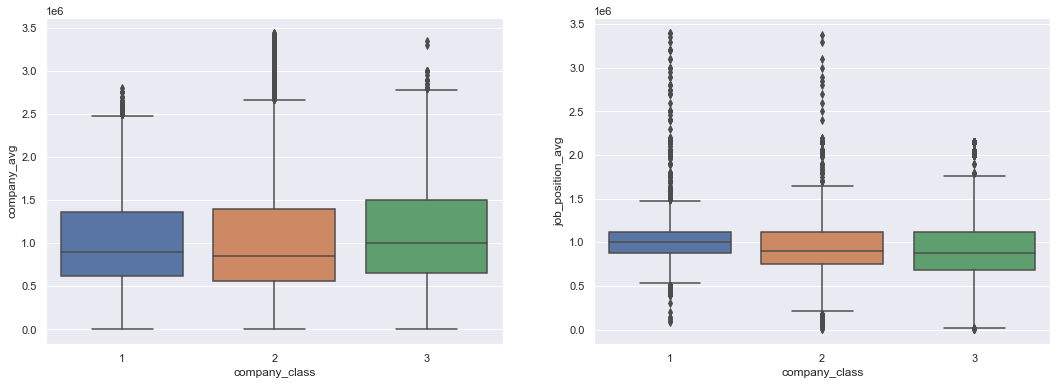

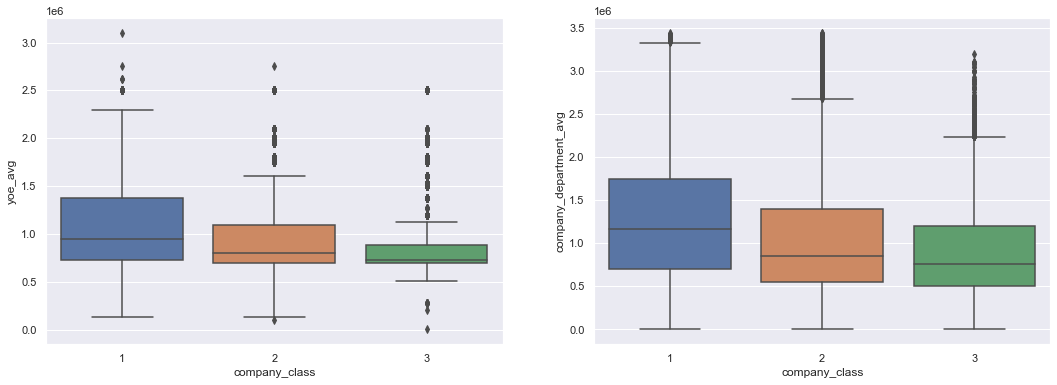

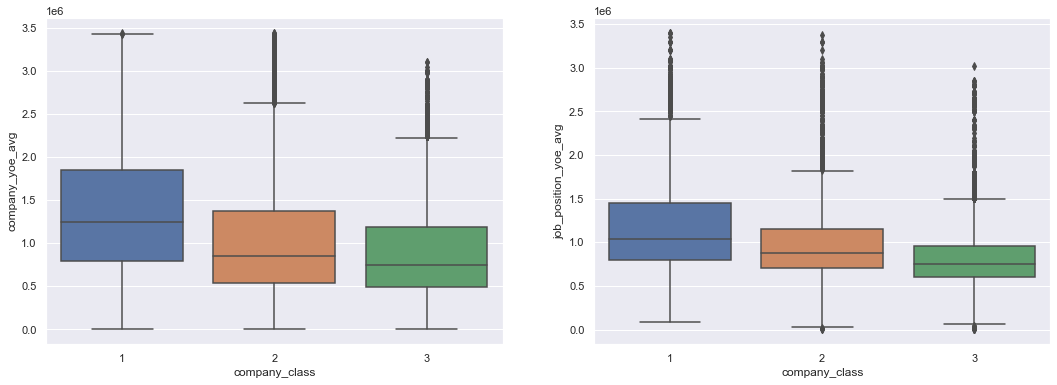

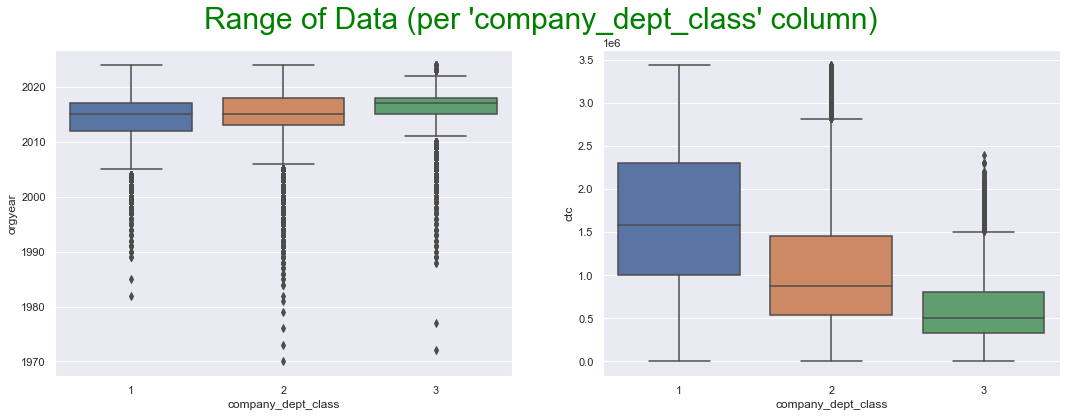

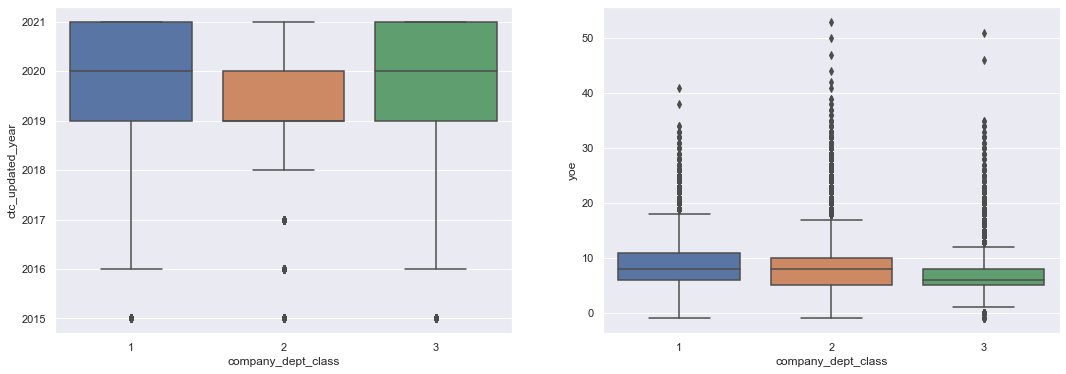

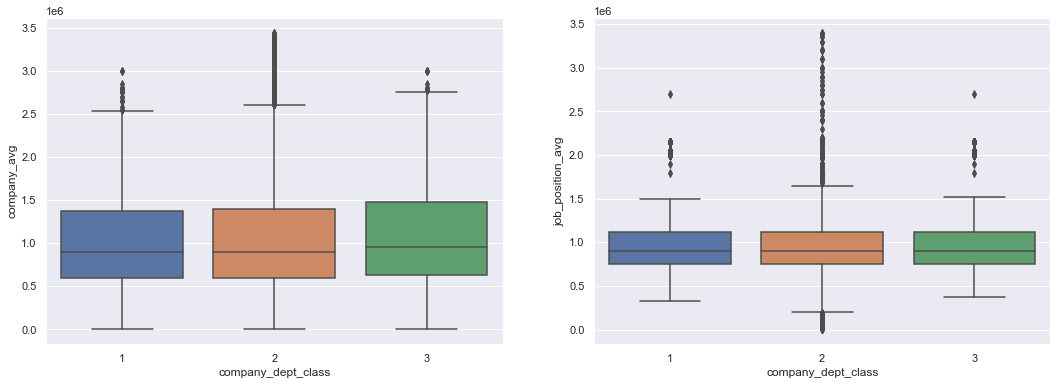

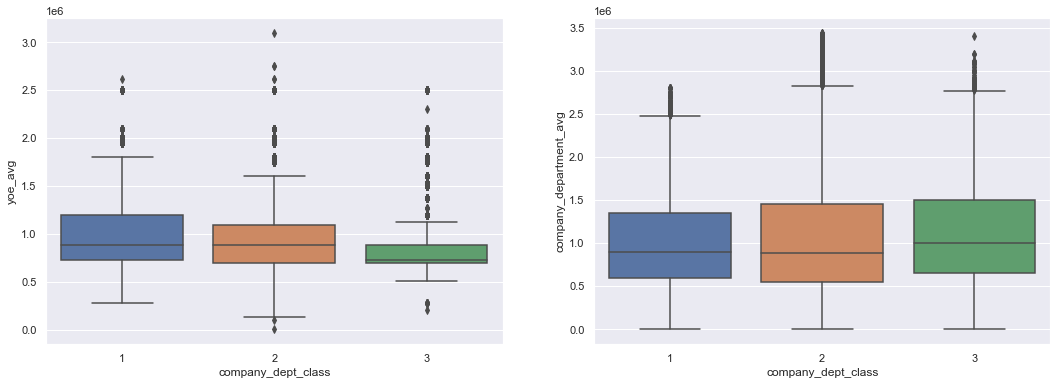

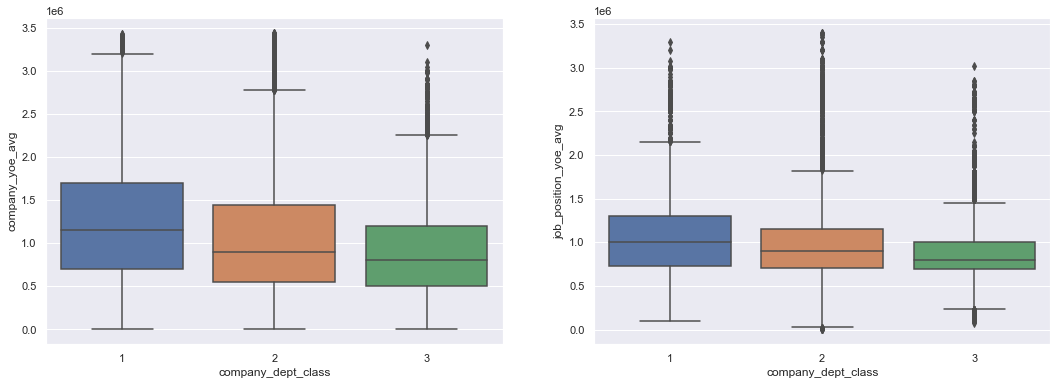

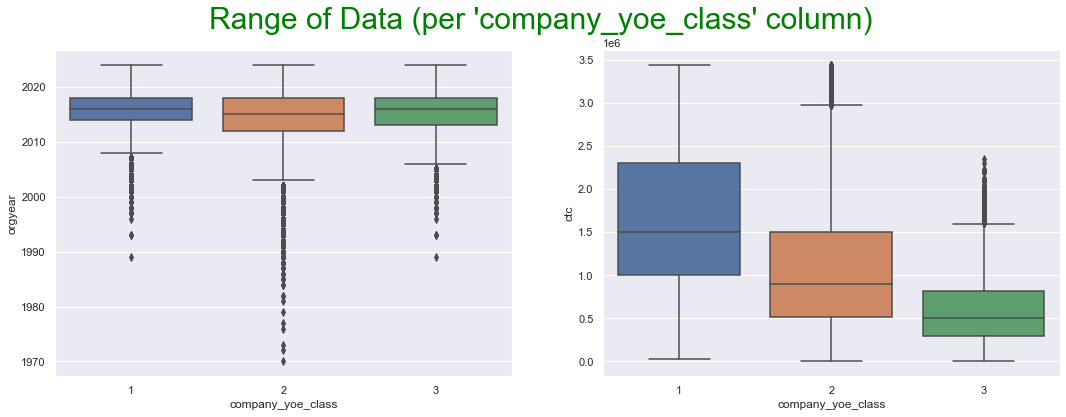

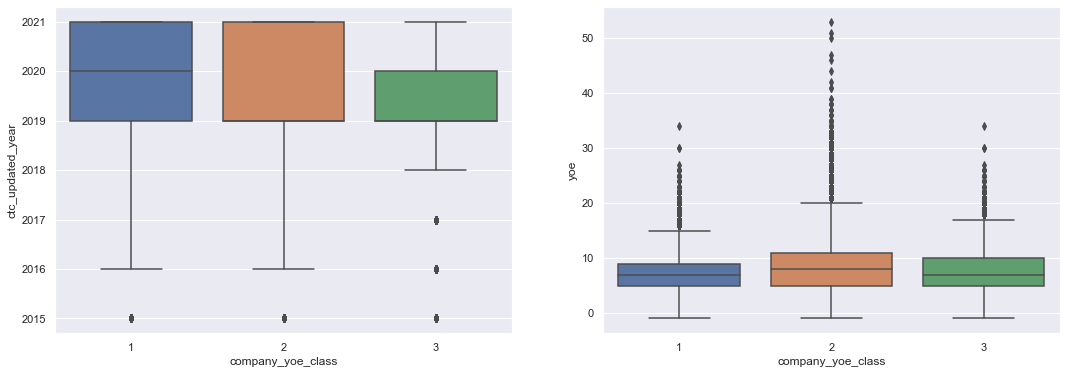

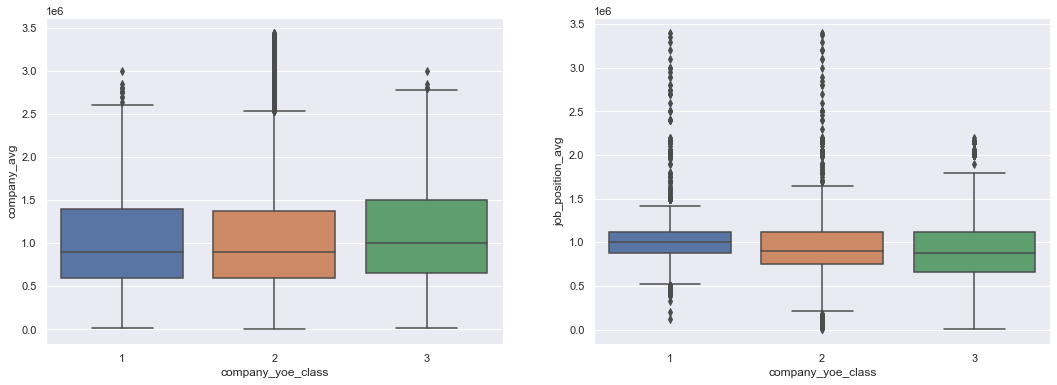

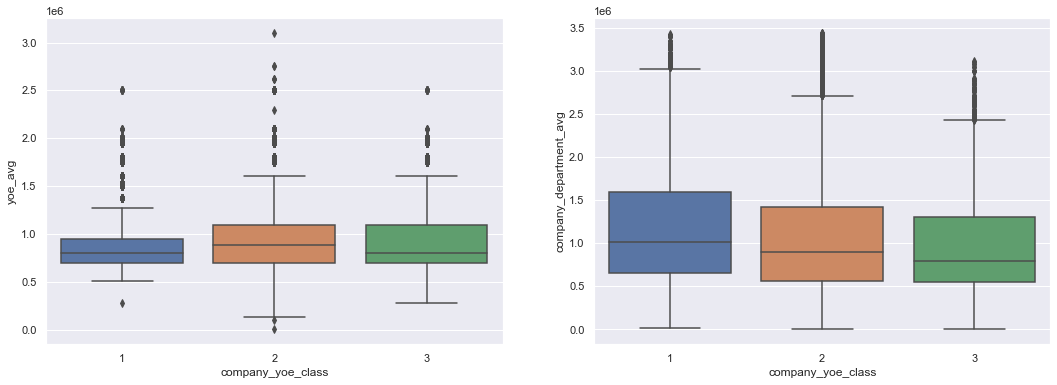

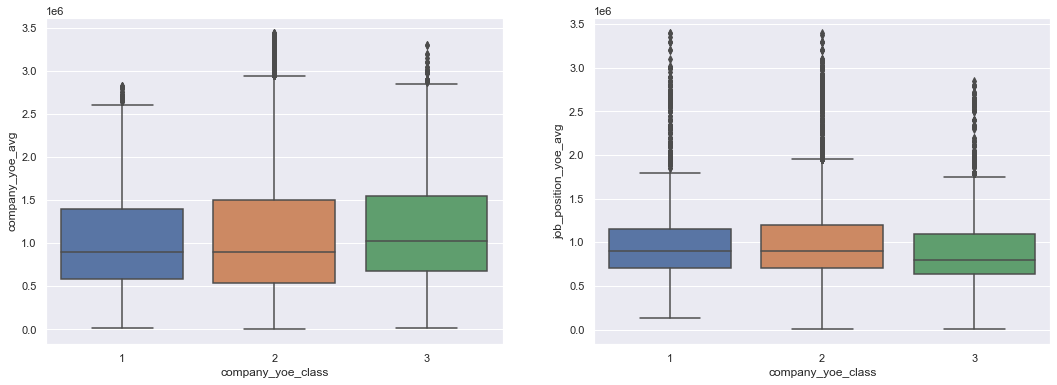

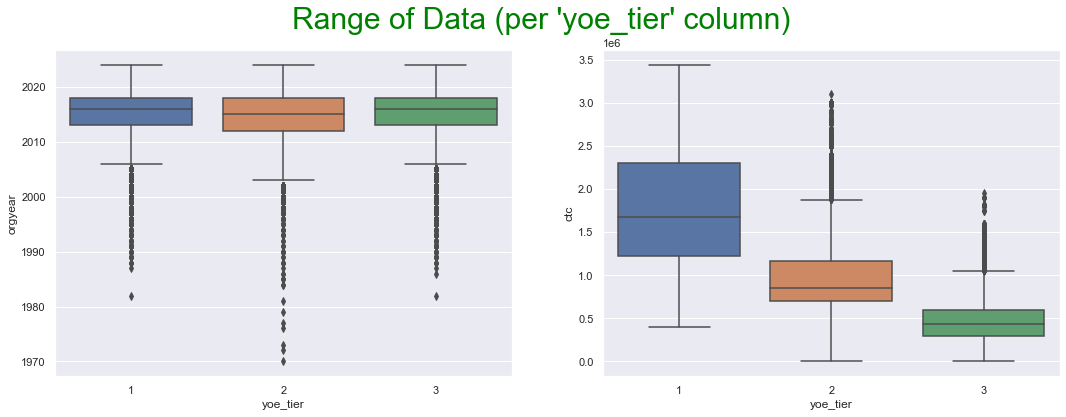

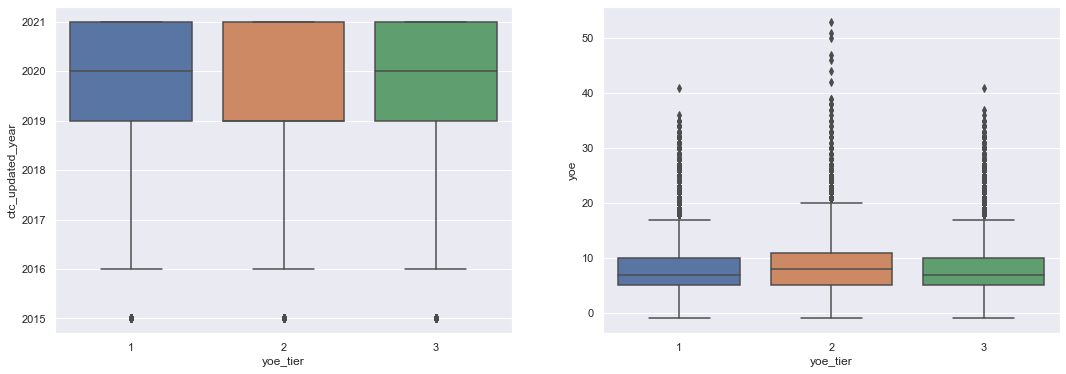

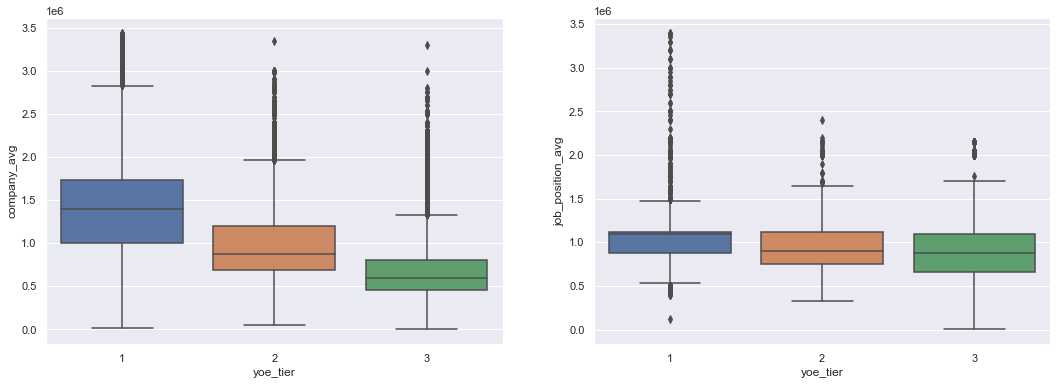

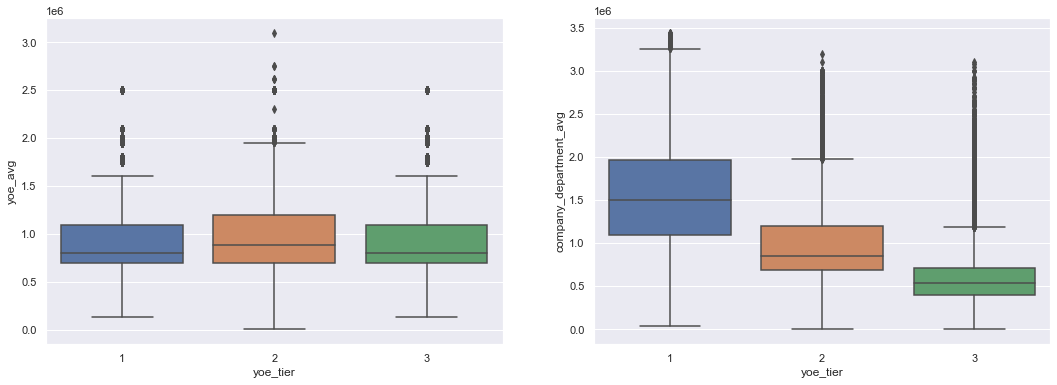

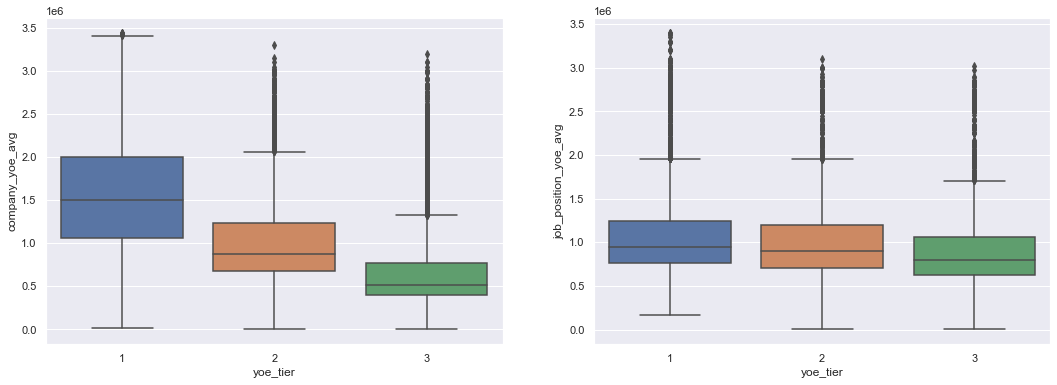

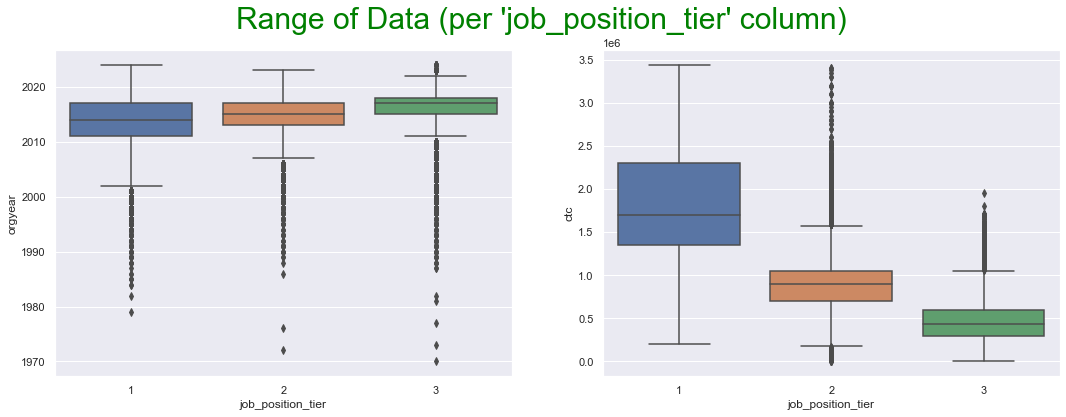

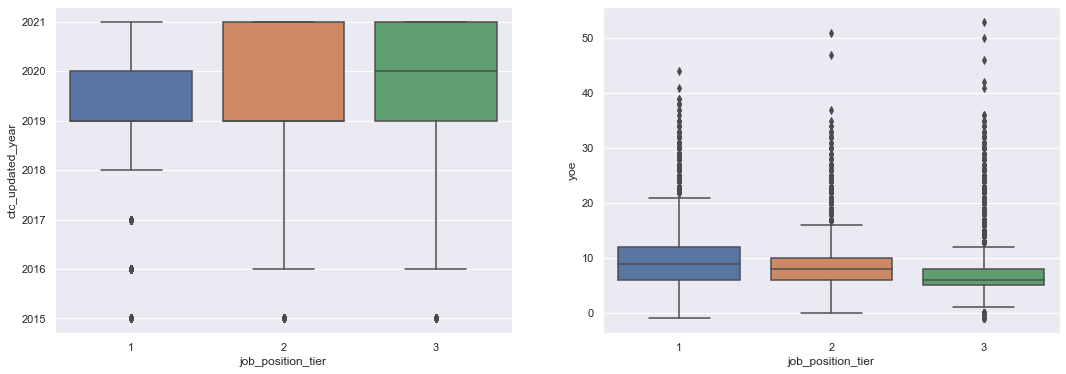

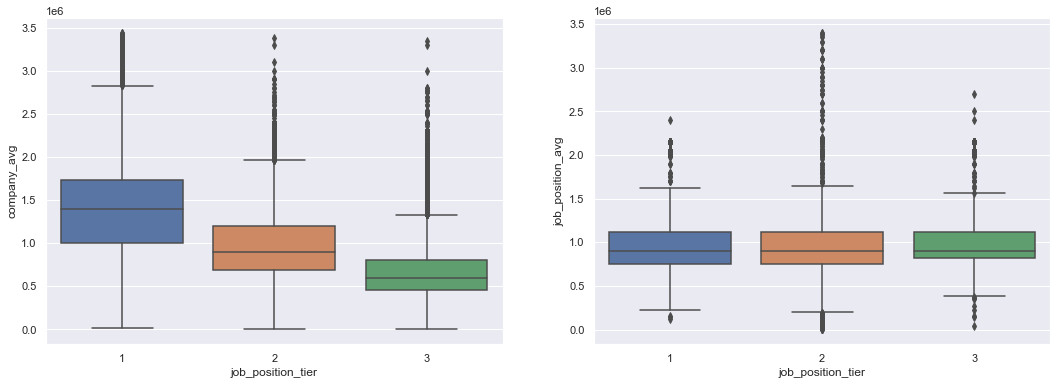

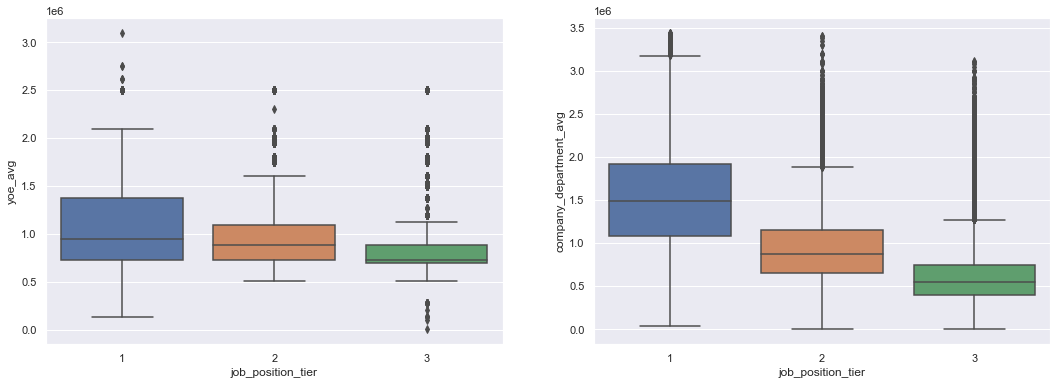

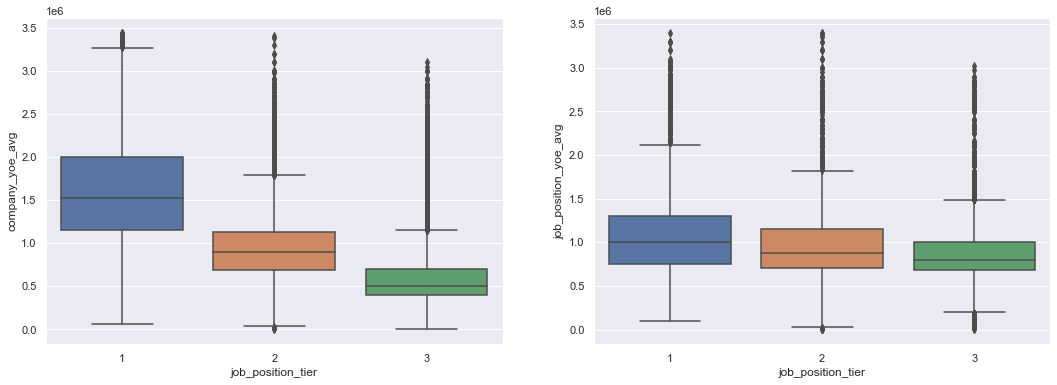

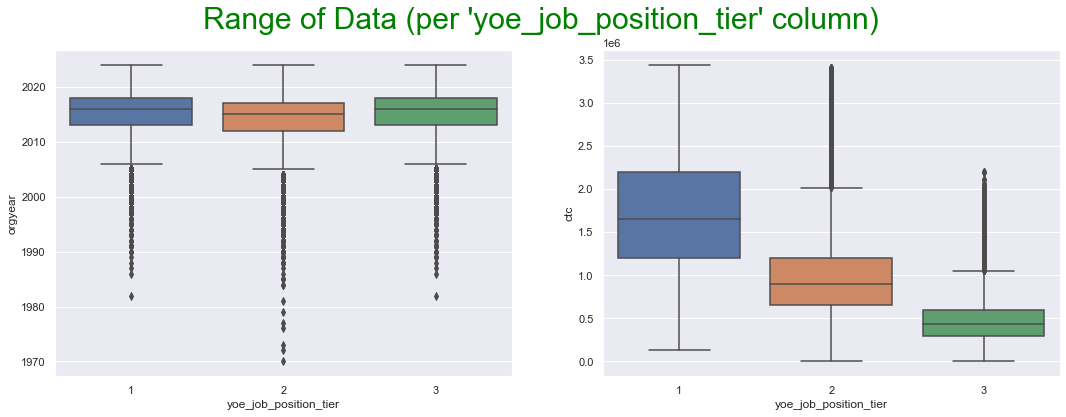

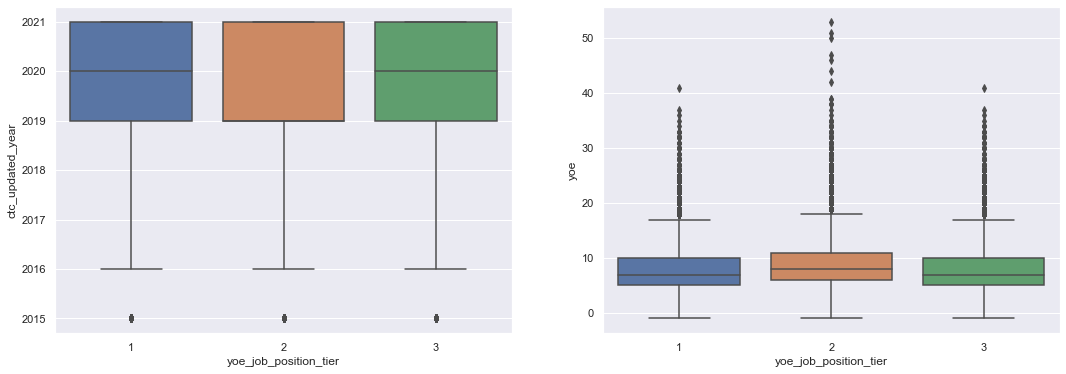

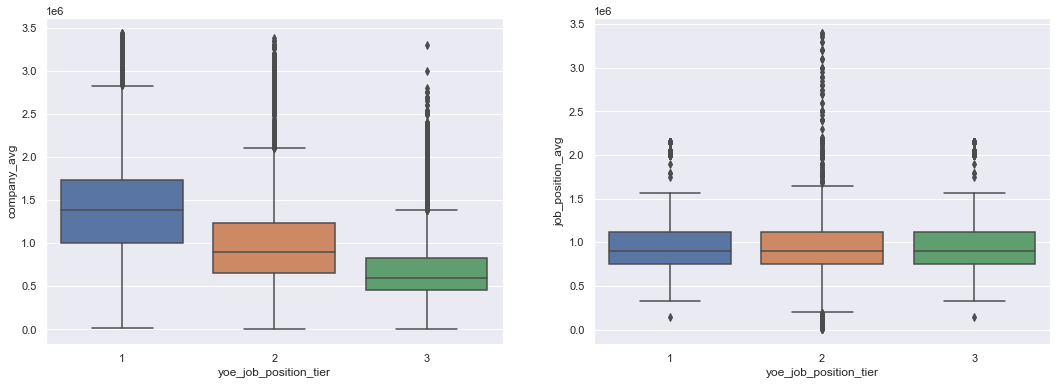

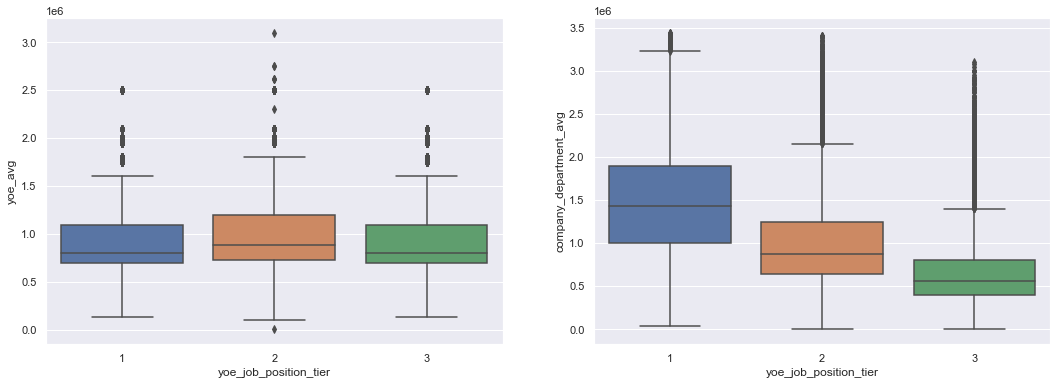

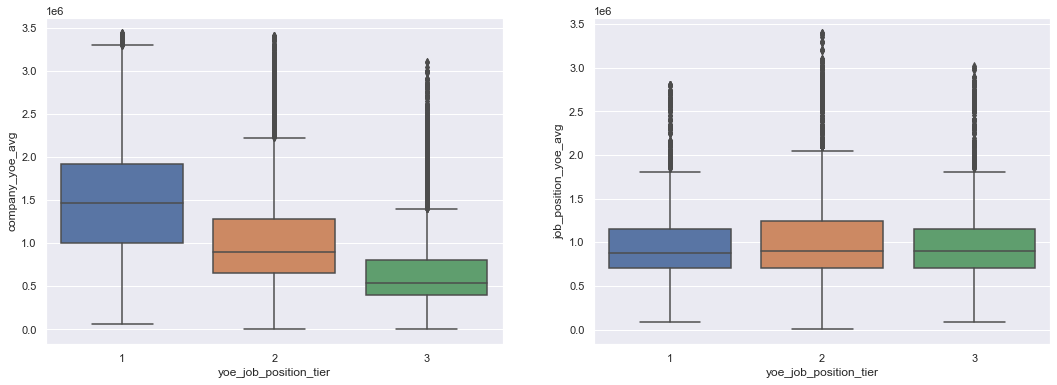

In [44]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **10. Correlation between different features.**

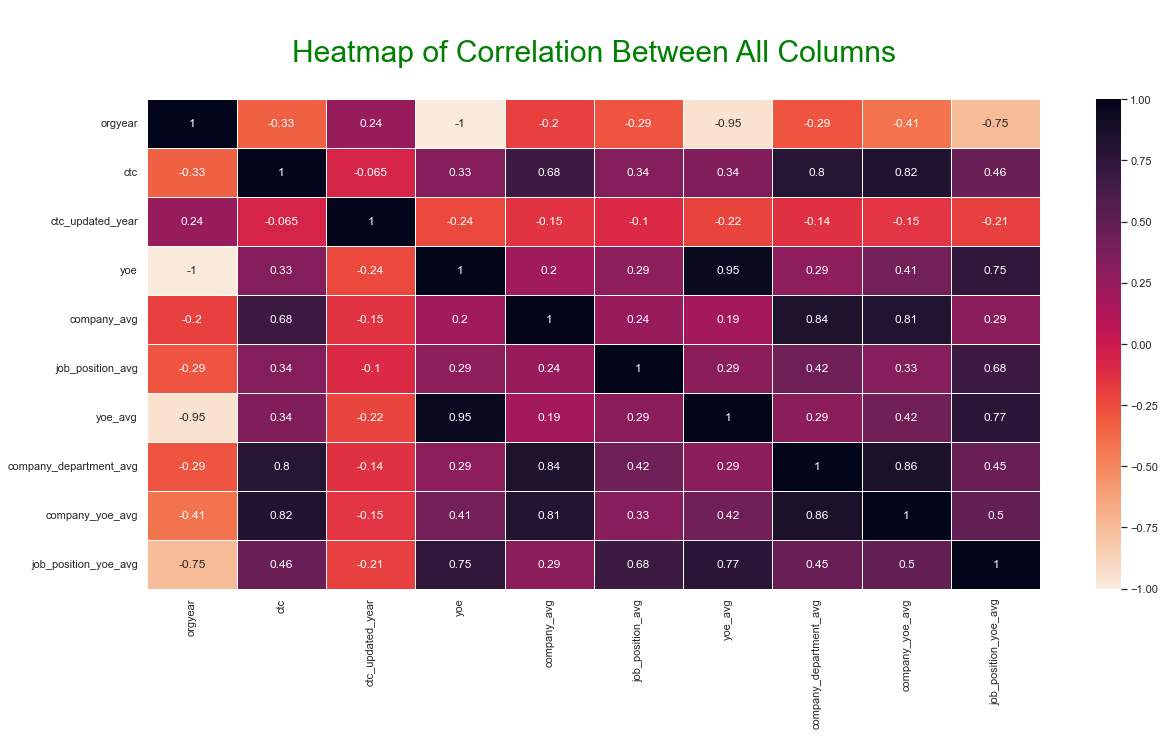

In [45]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **11. Manual Clustering - Analysis.**

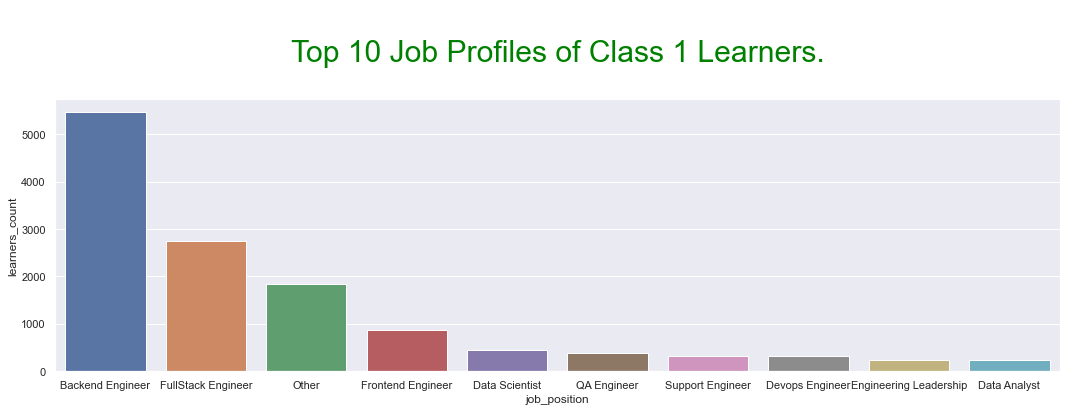

In [46]:
data = df[(df['company_class']==1) & (df['company_dept_class']==1) & (df['company_yoe_class']==1)]['job_position'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Job Profiles of Class 1 Learners.\n", fontsize=30, color="green")
plt.show()

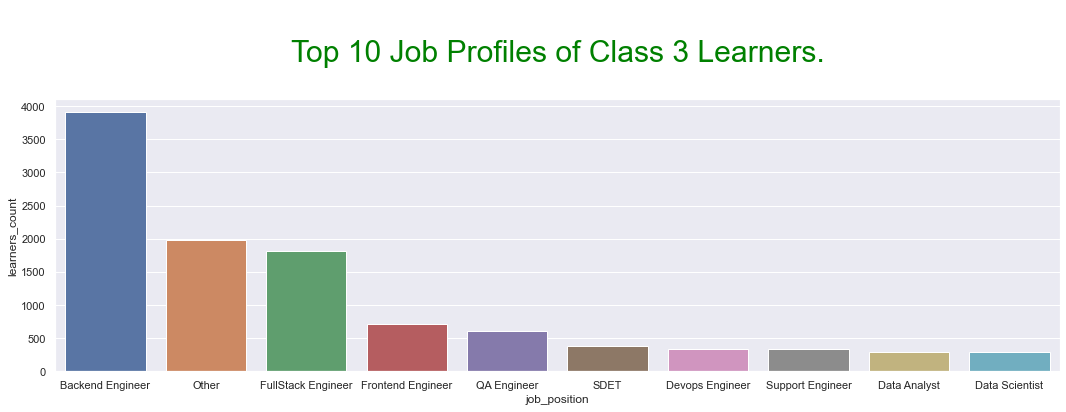

In [47]:
data = df[(df['company_class']==3) & (df['company_dept_class']==3) & (df['company_yoe_class']==3)]['job_position'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Job Profiles of Class 3 Learners.\n", fontsize=30, color="green")
plt.show()

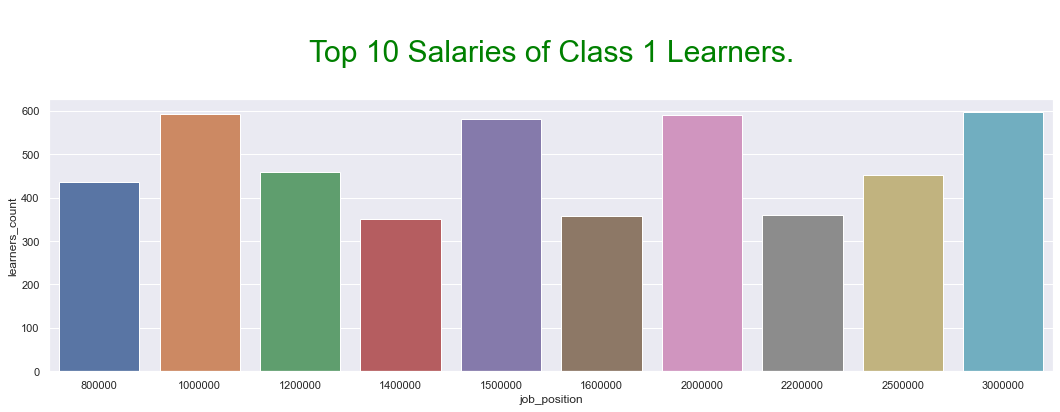

In [48]:
data = df[(df['company_class']==1) & (df['company_dept_class']==1) & (df['company_yoe_class']==1)]['ctc'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Salaries of Class 1 Learners.\n", fontsize=30, color="green")
plt.show()

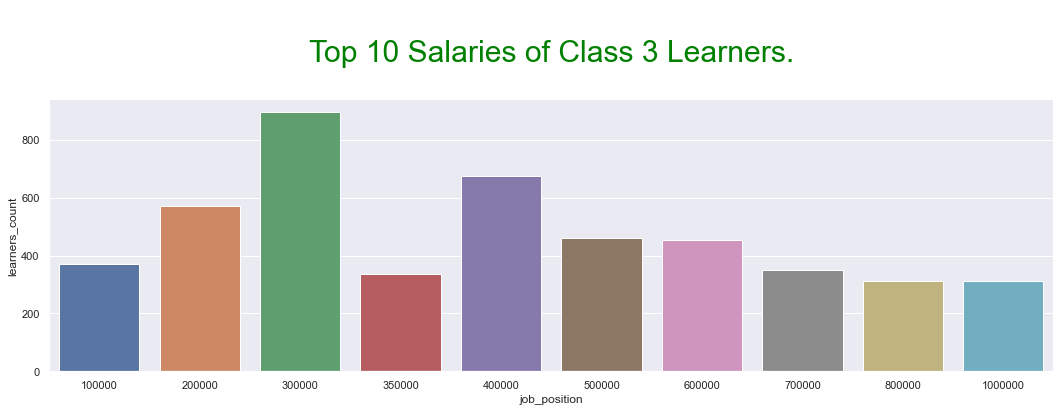

In [49]:
data = df[(df['company_class']==3) & (df['company_dept_class']==3) & (df['company_yoe_class']==3)]['ctc'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Salaries of Class 3 Learners.\n", fontsize=30, color="green")
plt.show()

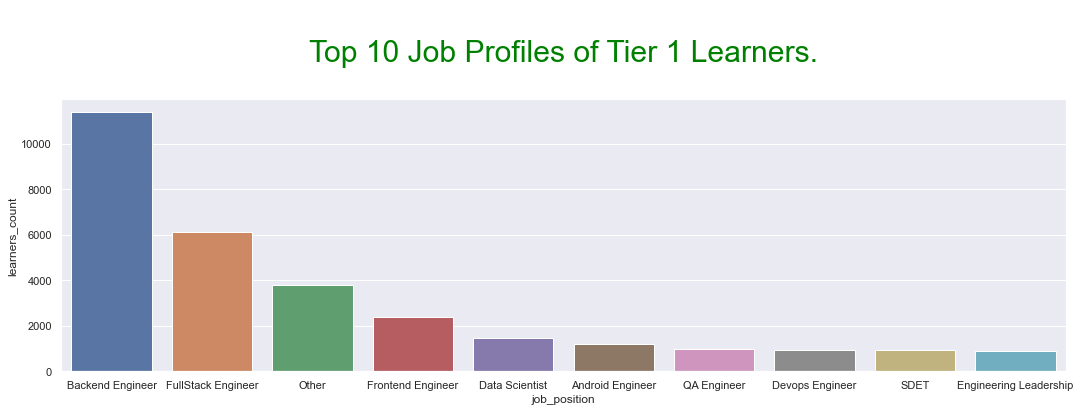

In [50]:
data = df[(df['yoe_tier']==1) & (df['job_position_tier']==1) & (df['yoe_job_position_tier']==1)]['job_position'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Job Profiles of Tier 1 Learners.\n", fontsize=30, color="green")
plt.show()

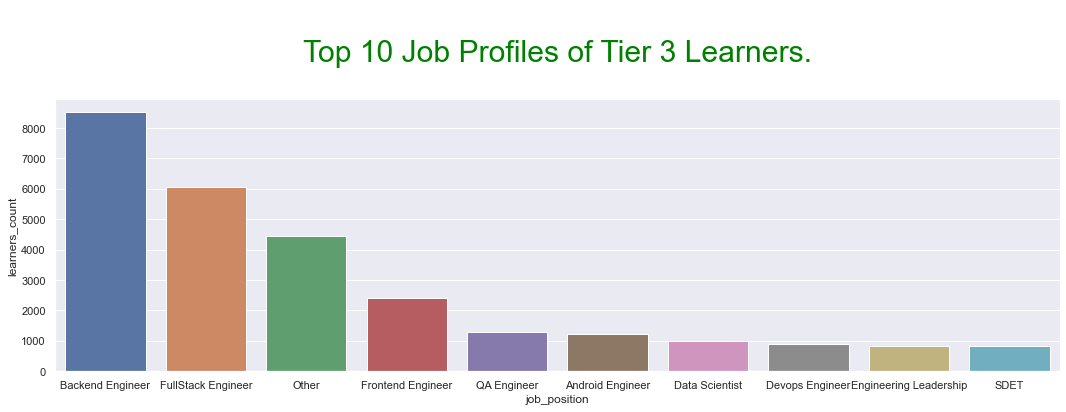

In [51]:
data = df[(df['yoe_tier']==3) & (df['job_position_tier']==3) & (df['yoe_job_position_tier']==3)]['job_position'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Job Profiles of Tier 3 Learners.\n", fontsize=30, color="green")
plt.show()

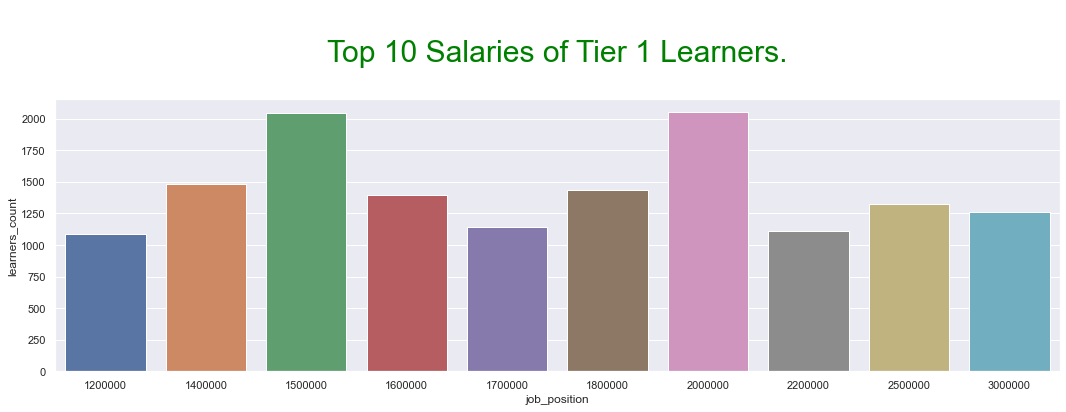

In [52]:
data = df[(df['yoe_tier']==1) & (df['job_position_tier']==1) & (df['yoe_job_position_tier']==1)]['ctc'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Salaries of Tier 1 Learners.\n", fontsize=30, color="green")
plt.show()

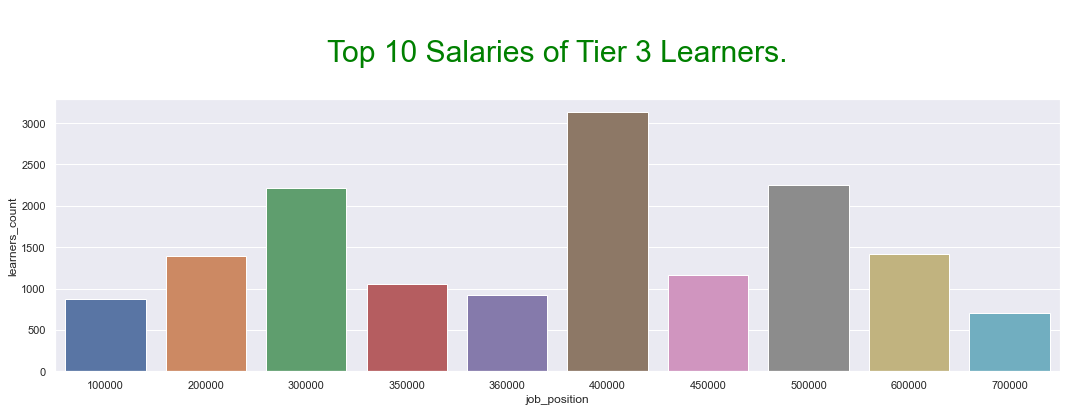

In [53]:
data = df[(df['yoe_tier']==3) & (df['job_position_tier']==3) & (df['yoe_job_position_tier']==3)]['ctc'].value_counts()[:10]
data = pd.DataFrame(data).reset_index()
data.columns = ['job_position', 'learners_count']
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=data, x='job_position', y='learners_count')
plt.title(f"\nTop 10 Salaries of Tier 3 Learners.\n", fontsize=30, color="green")
plt.show()

***
***
## **12. Preprocessing - Scaling Data.**

In [54]:
training_data = df[list(df.columns[-6:])+['ctc', 'yoe']]

In [55]:
scaler = StandardScaler()
training_data = pd.DataFrame(scaler.fit_transform(training_data), columns = training_data.columns)

In [56]:
training_data.head()

company_class  company_dept_class  company_yoe_class  yoe_tier  \
0       0.042163            0.044193           0.044607  1.172009   
1      -1.366455           -1.591869           0.044607 -1.126276   
2       1.450782            1.680255           1.771095  1.172009   
3      -1.366455            0.044193           0.044607 -1.126276   
4      -1.366455           -1.591869           0.044607  1.172009   

   job_position_tier  yoe_job_position_tier       ctc       yoe  
0           1.196697               1.234828 -1.125365  0.441448  
1          -1.123985               0.035306  0.585787  0.441448  
2           1.196697               1.234828 -0.664670  0.441448  
3          -1.123985              -1.164216  1.178108  0.441448  
4           1.196697               1.234828 -0.533043  0.441448

***
***
## **13. Varifying Clustering Tendency.**

***
***
### **Dimensionality Reduction.**

In [57]:
principal=PCA(n_components=2)
principal.fit(training_data)
reduced_data=pd.DataFrame(principal.transform(training_data), columns=['x', 'y'])

<AxesSubplot:xlabel='x', ylabel='y'>

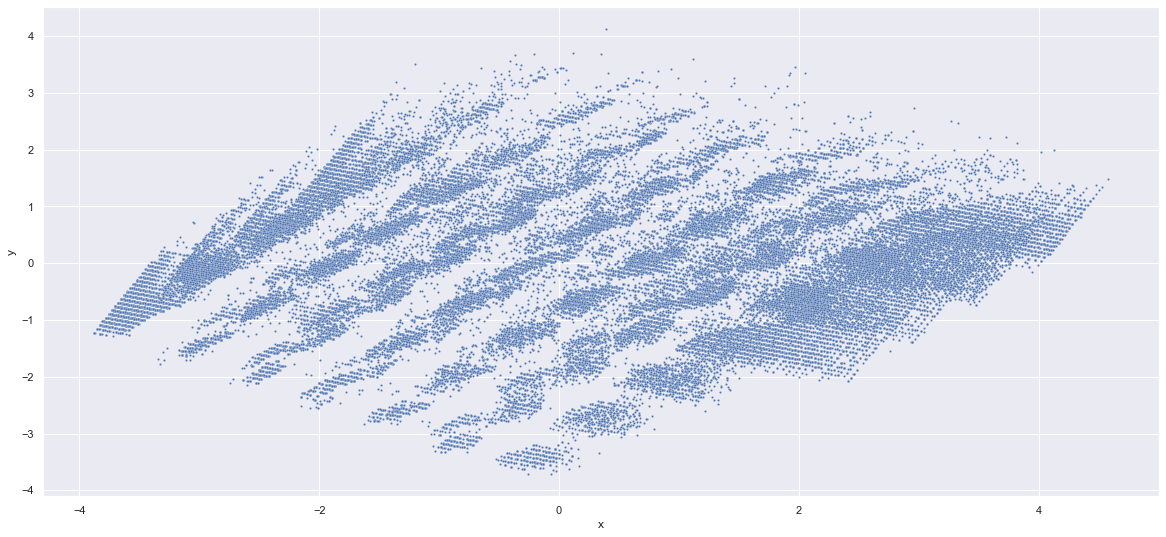

In [58]:
fig, ax = plt.subplots(figsize=(20,9))
sns.scatterplot(data=reduced_data, x='x', y='y', s=5)

***
***
### **Hopkins Method.**

### Null hypothesis: the data set is uniformly distributed (i.e., no meaningful clusters)
### Alternative hypothesis: the data set is not uniformly distributed (i.e., contains meaningful clusters)

In [59]:
statistic = hopkins(training_data)
print("Test Statistic:", statistic)

Test Statistic: 0.9927749209204938


### Rejected Null hypothesis: the data contains meaningful clusters.

***
***
## **14. K Means Clustering - Elbow Method.**

In [60]:
wcss = []
ind = []
for i in range(1, 11):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(training_data)
    wcss.append(model.inertia_)
    ind.append(i)
elbow_data = pd.DataFrame({'K':ind, 'Inertia':wcss})

<AxesSubplot:xlabel='K', ylabel='Inertia'>

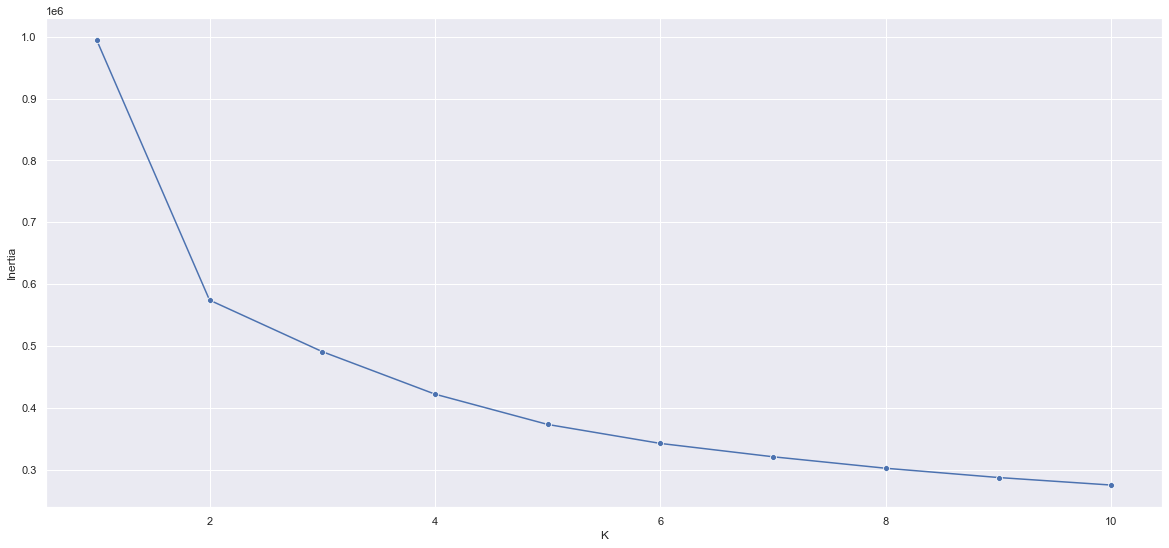

In [61]:
fig, ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=elbow_data, x='K', y='Inertia', marker='o')

***
***
## **15. K Means Clustering - Model Building.**

In [62]:
model = KMeans(n_clusters=4, random_state=0)
model.fit(training_data)

KMeans(n_clusters=4, random_state=0)

In [63]:
df['cluster'] = model.labels_
df = convert_to_best_type(df)

In [64]:
df.head()

email_hash  \
0  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
1  3e3b5b1152033db04deabf6d1e10b5e48bbc87ee112a7d...   
2  8fe63f3fb51224450ca6590dac3c8f60bf01d8823f6770...   
3  b71bffcdc39f13604559ce460d3fbaf7cef21e671ea94e...   
4  0f997b4eca69c18f4d37b0dcb4f02732d747ff3febbef5...   

                company_hash  orgyear      ctc  ctc_updated_year  \
0               nqsn axsxnvr   2013.0   250000            2020.0   
1                      gunhb   2013.0  1550000            2020.0   
2                      gunhb   2013.0   600000            2017.0   
3      bxwqgotbx wgqugqvnxgz   2013.0  2000000            2019.0   
4  nvnv wgzohrnvzwj otqcxwto   2013.0   700000            2021.0   

       job_position   yoe  company_avg  job_position_avg    yoe_avg  \
0  Backend Engineer  10.0     250000.0         1120000.0  1095000.0   
1  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
2  Backend Engineer  10.0    1250000.0         1120000.0  1095000.0   
3  Backend Engineer  10.0    1625000.0         1120000.0  1095000.0   
4  Backend Engineer  10.0     455000.0         1120000.0  1095000.0   

   company_department_avg  company_yoe_avg  job_position_yoe_avg  \
0                250000.0         250000.0             1400000.0   
1               1265000.0        1350000.0             1400000.0   
2               1265000.0        1350000.0             1400000.0   
3               2000000.0        2000000.0             1400000.0   
4                476500.0         700000.0             1400000.0   

  company_class company_dept_class company_yoe_class yoe_tier  \
0             2                  2                 2        3   
1             1                  1                 2        1   
2             3                  3                 3        3   
3             1                  2                 2        1   
4             1                  1                 2        3   

  job_position_tier yoe_job_position_tier cluster  
0                 3                     3       2  
1                 1                     2       3  
2                 3                     3       1  
3                 1                     1       3  
4                 3                     3       2

***
***
## **16. Analyzing Clusters - Bivariate.**

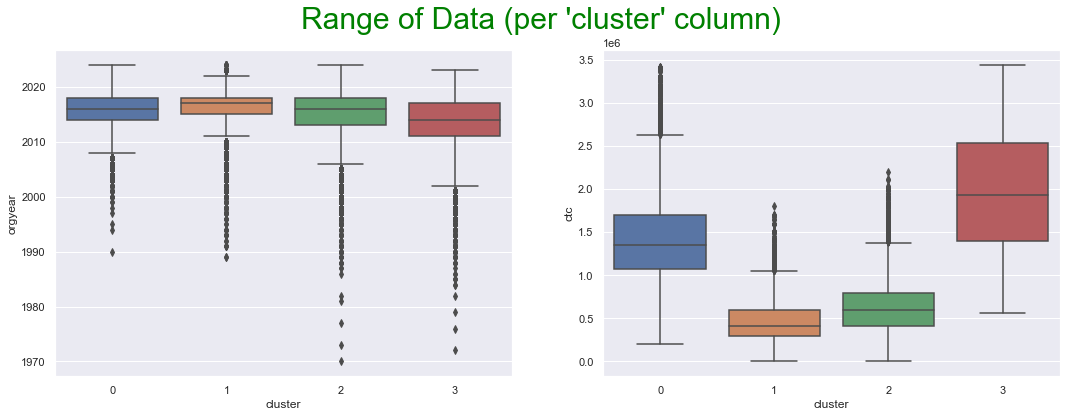

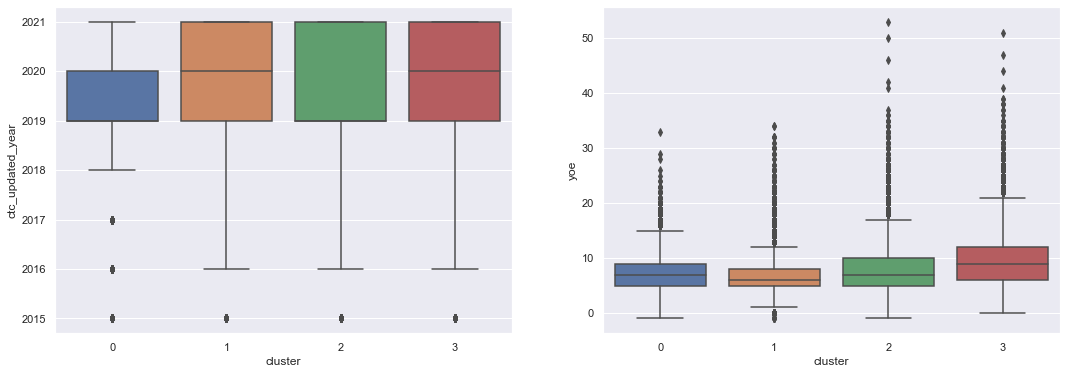

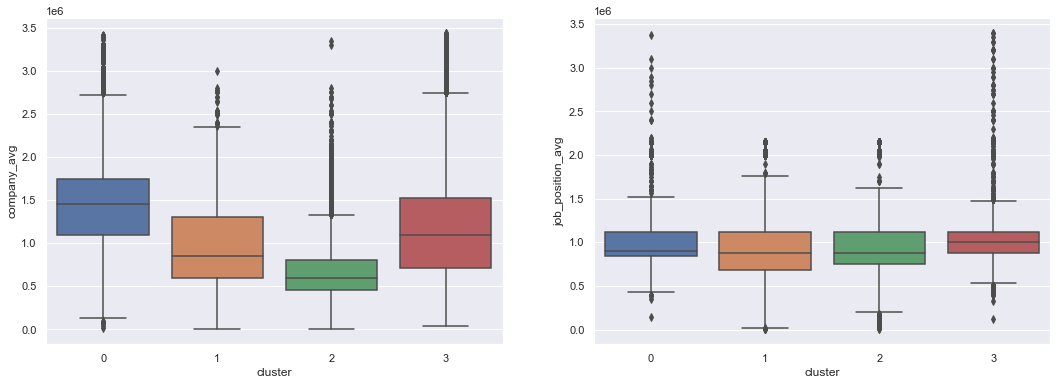

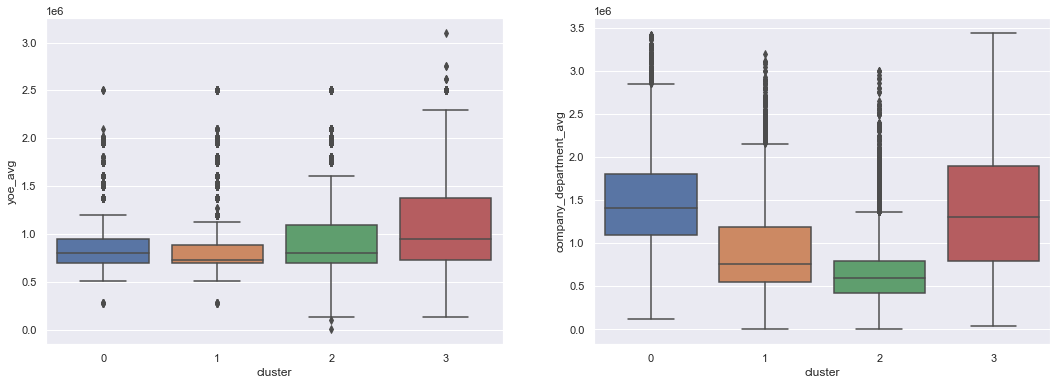

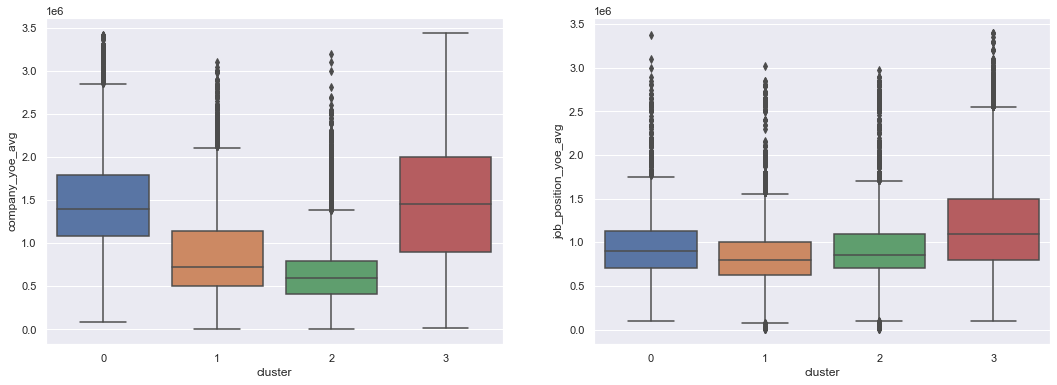

In [65]:
for category in ['cluster']:
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **16. Analyzing Clusters - Multivariate.**

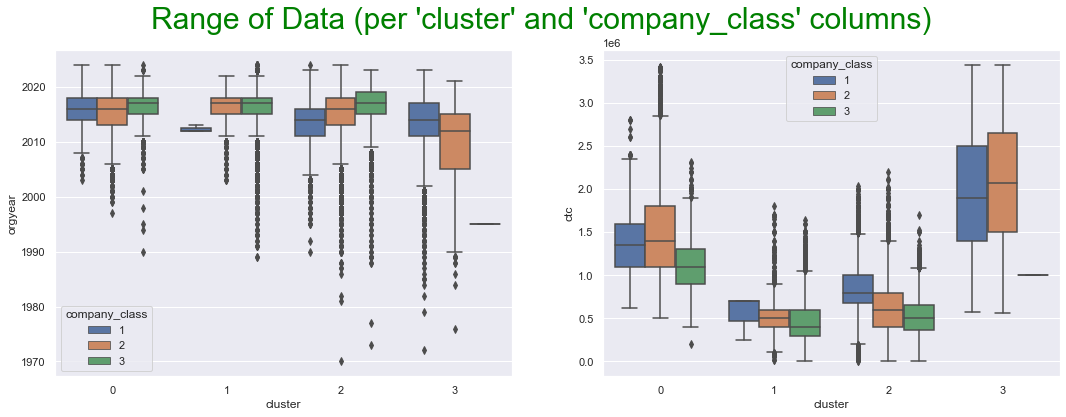

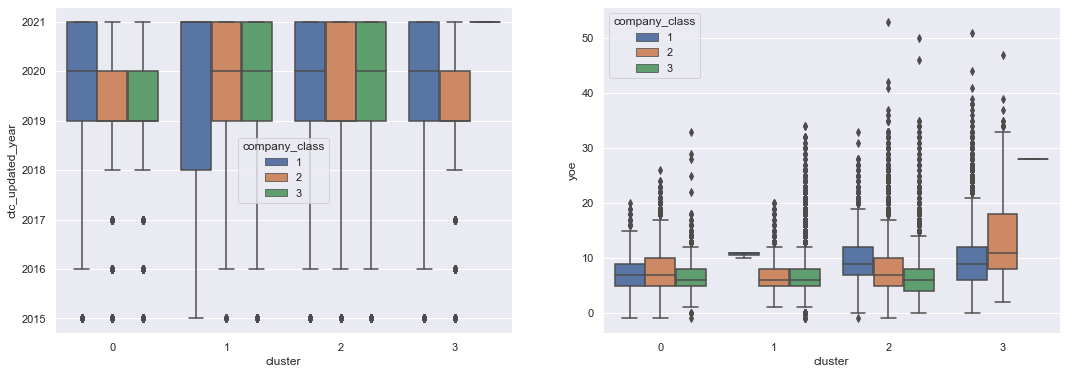

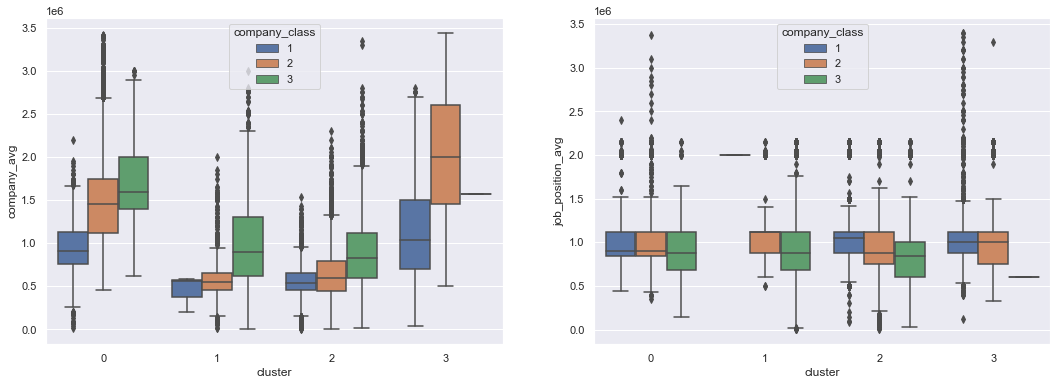

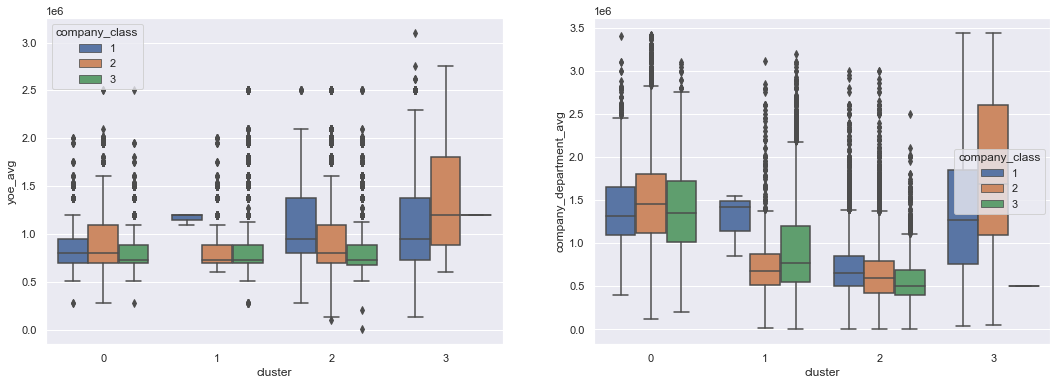

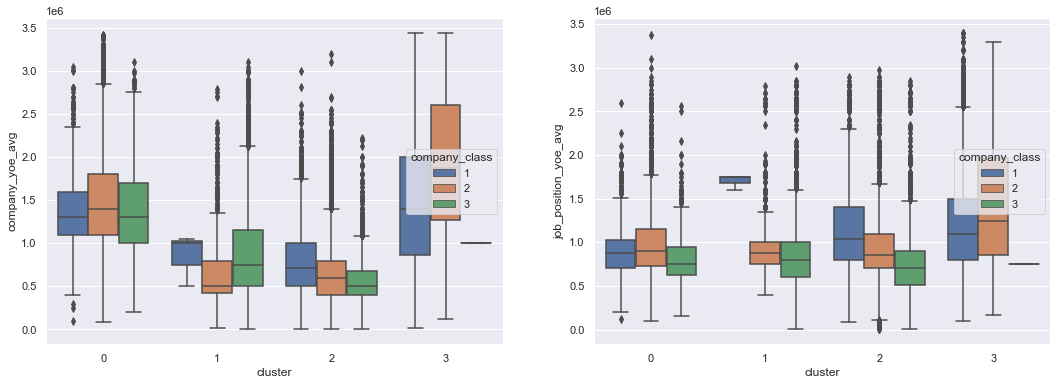

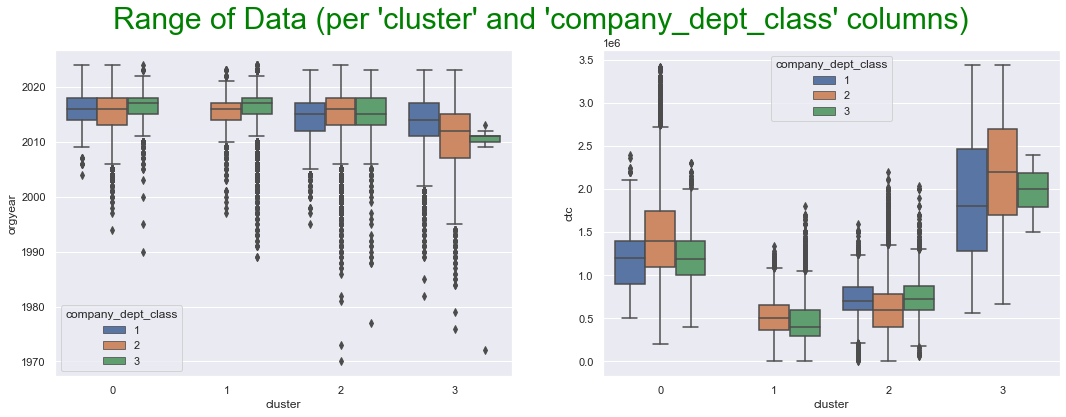

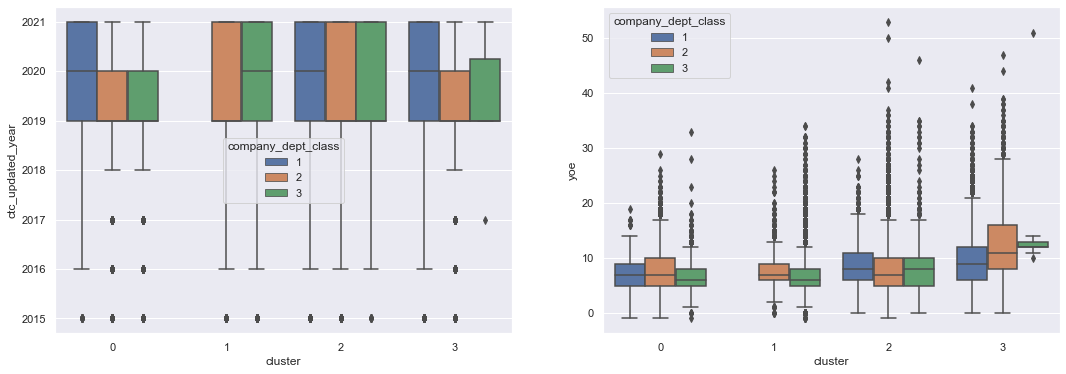

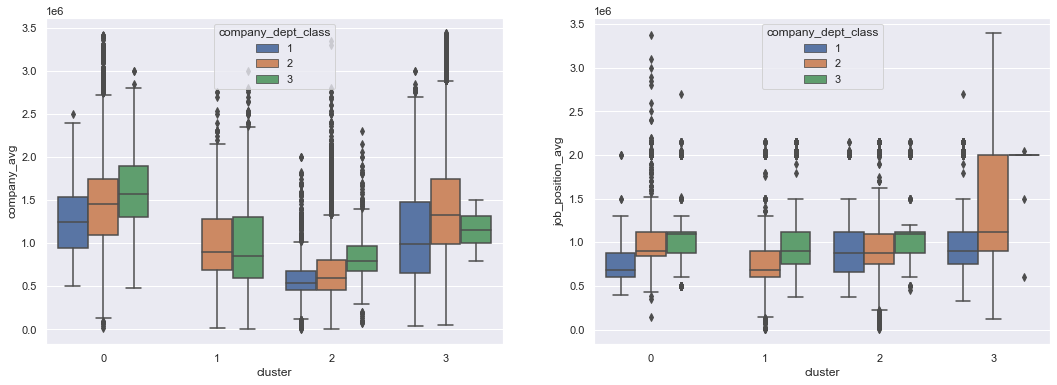

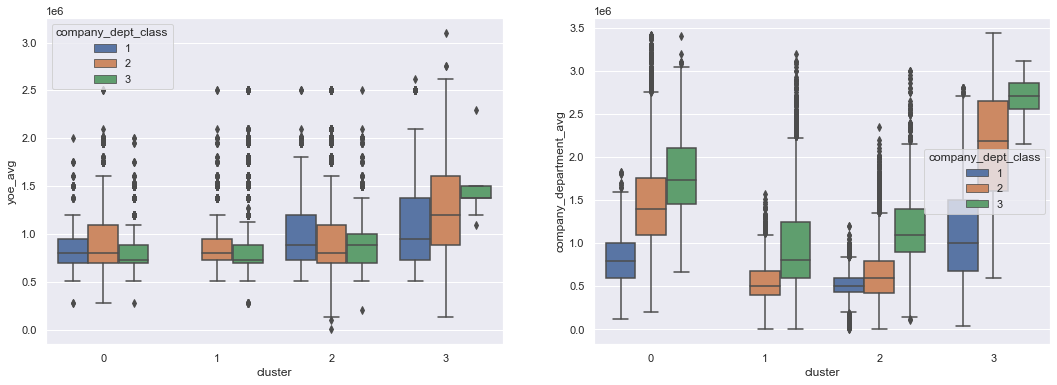

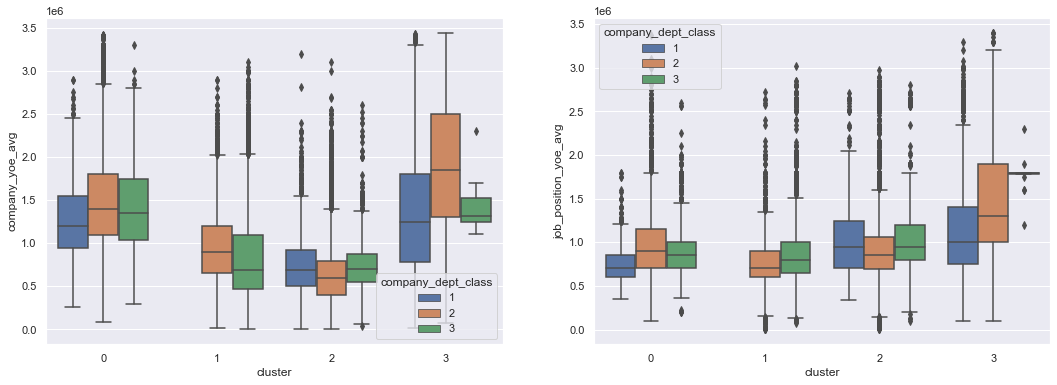

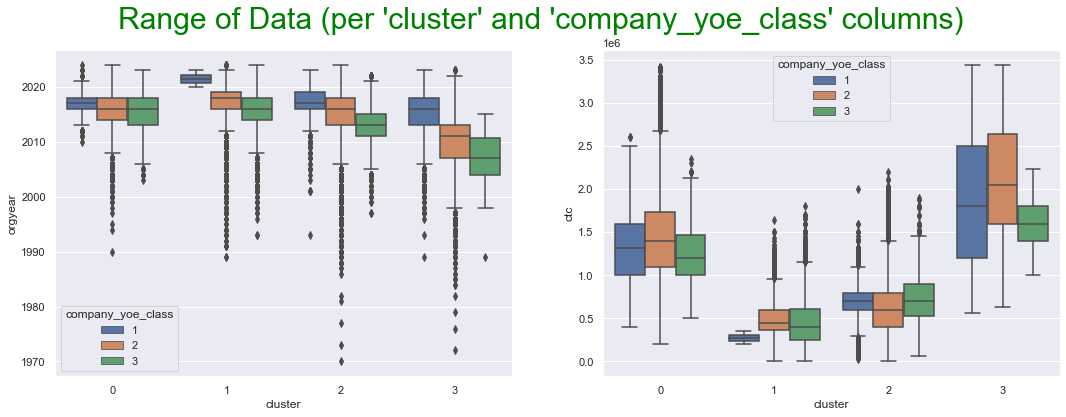

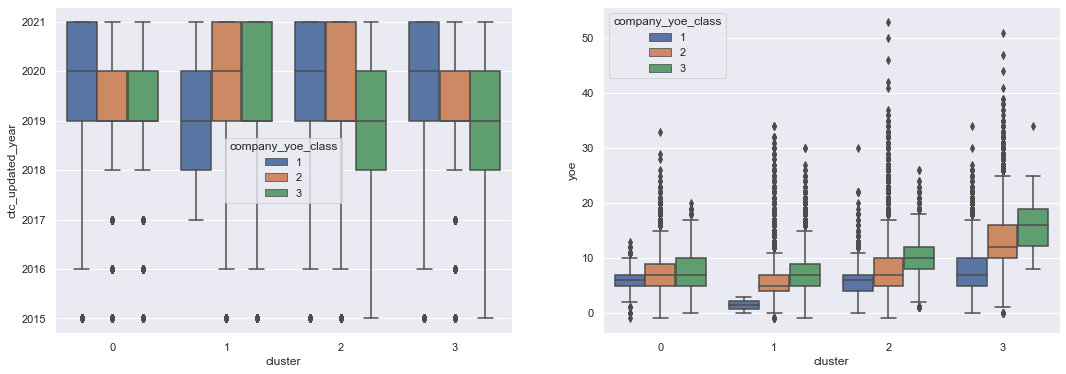

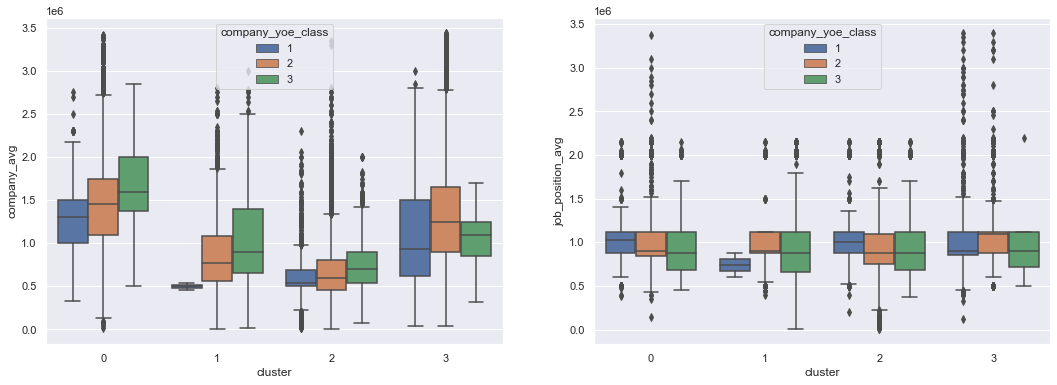

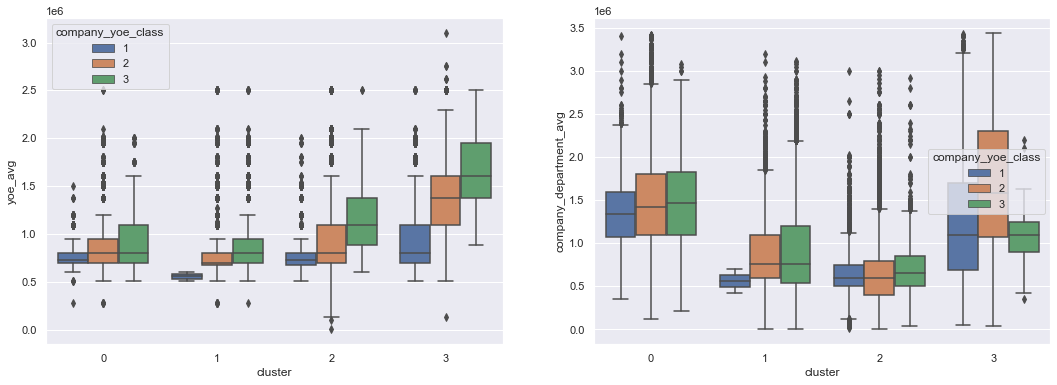

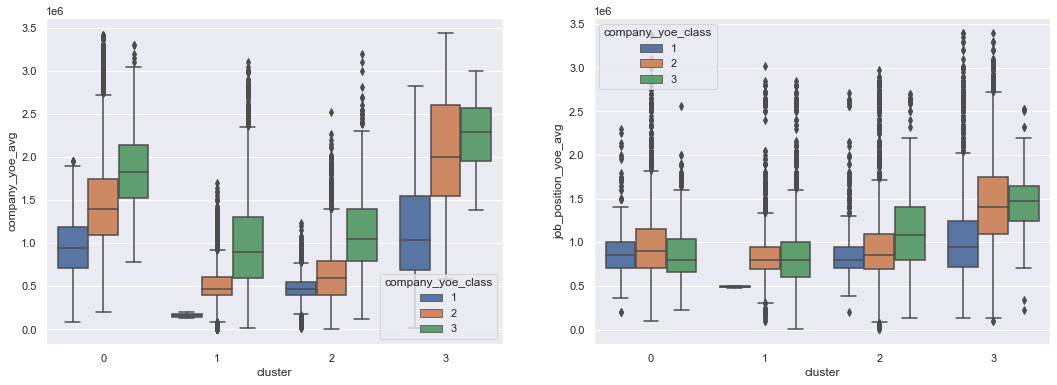

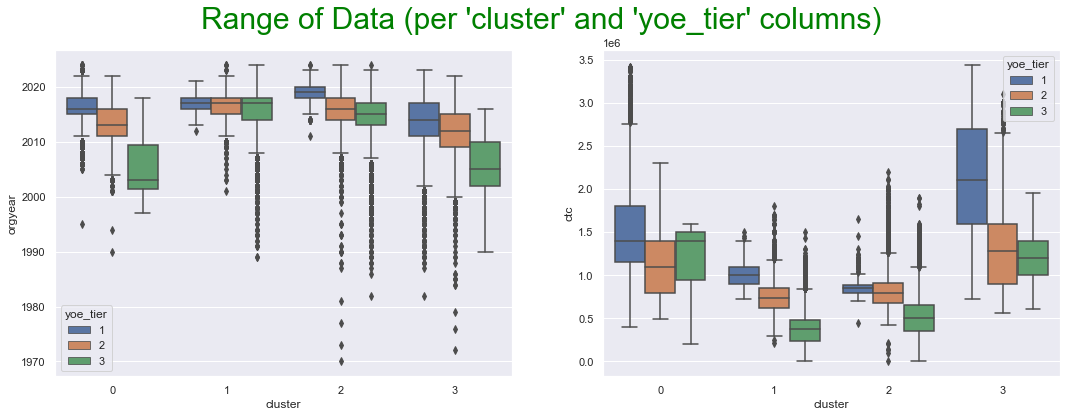

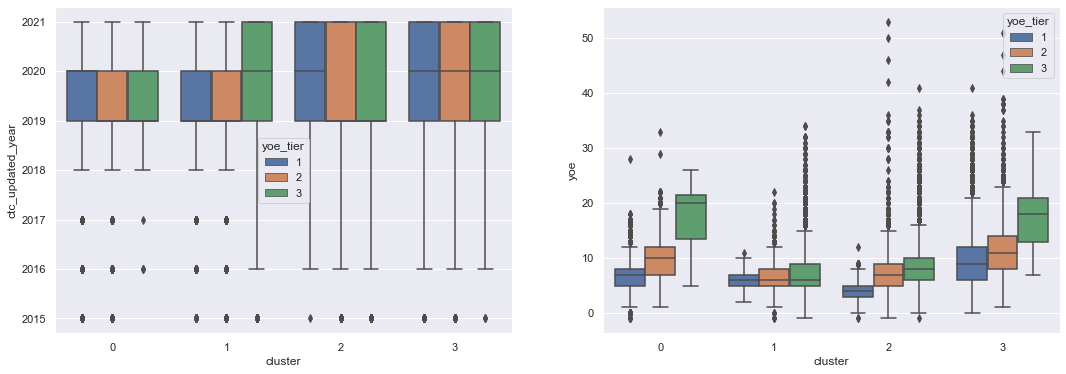

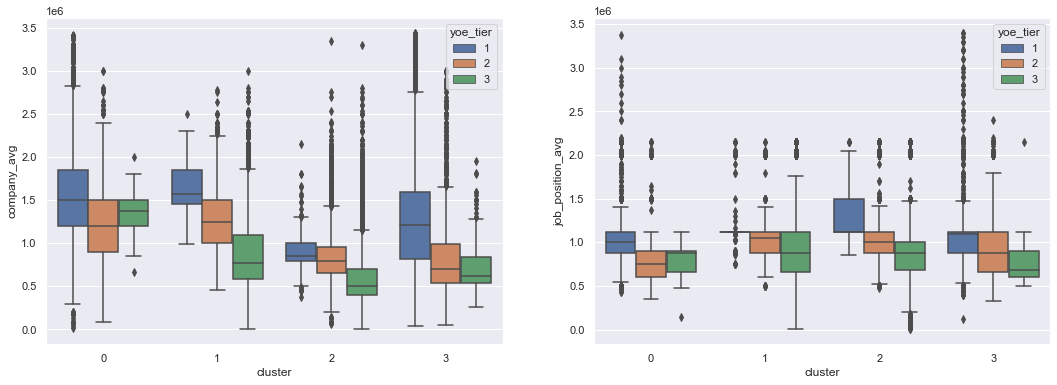

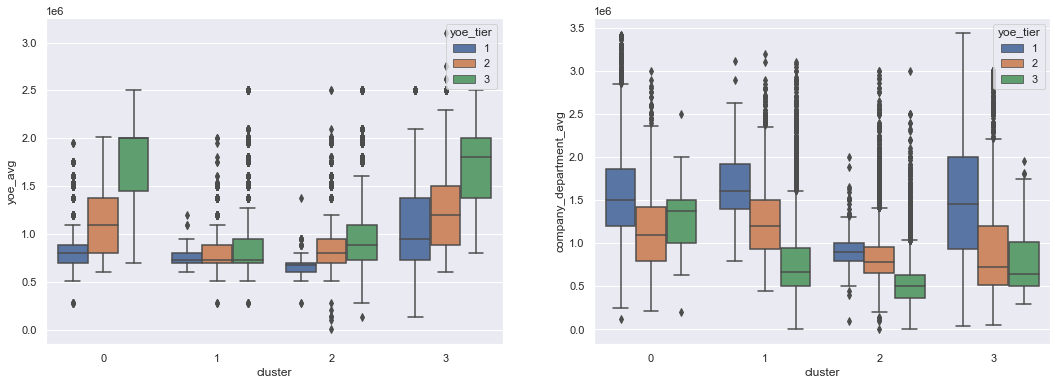

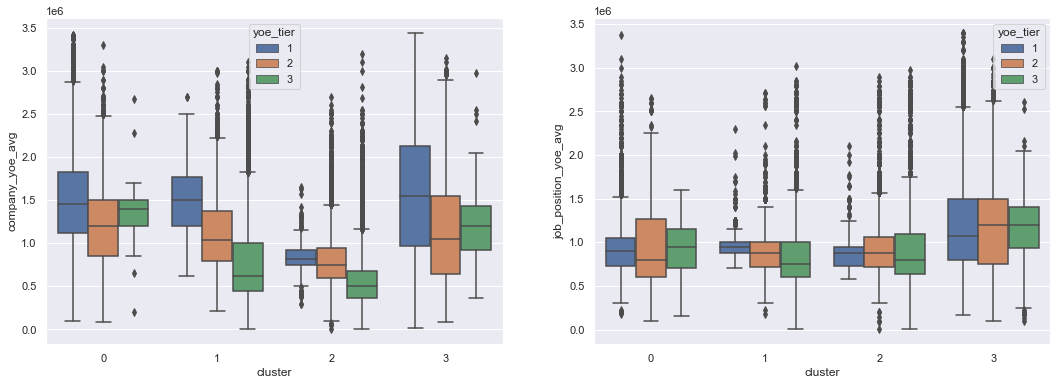

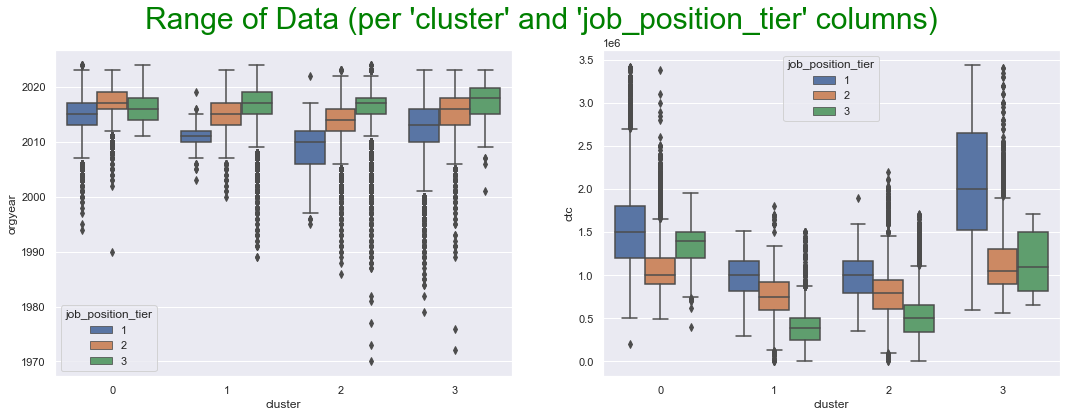

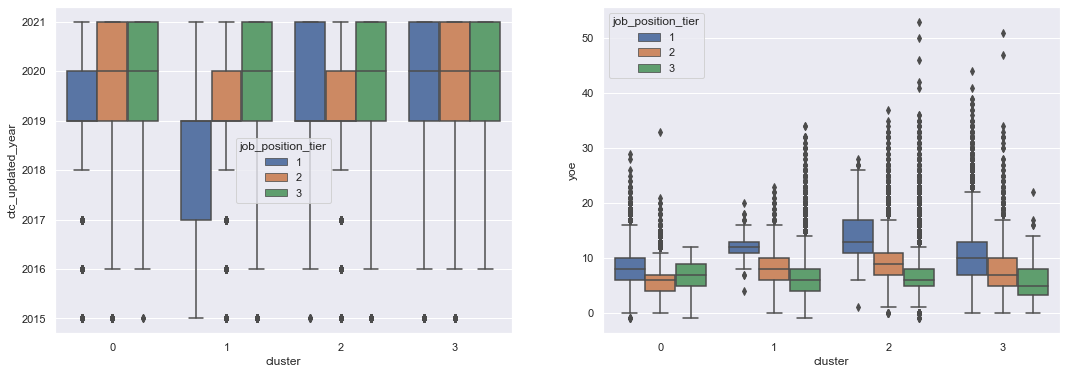

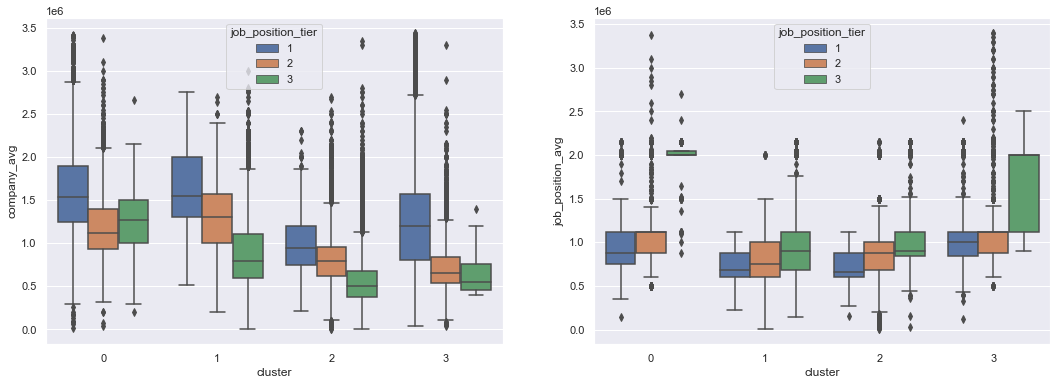

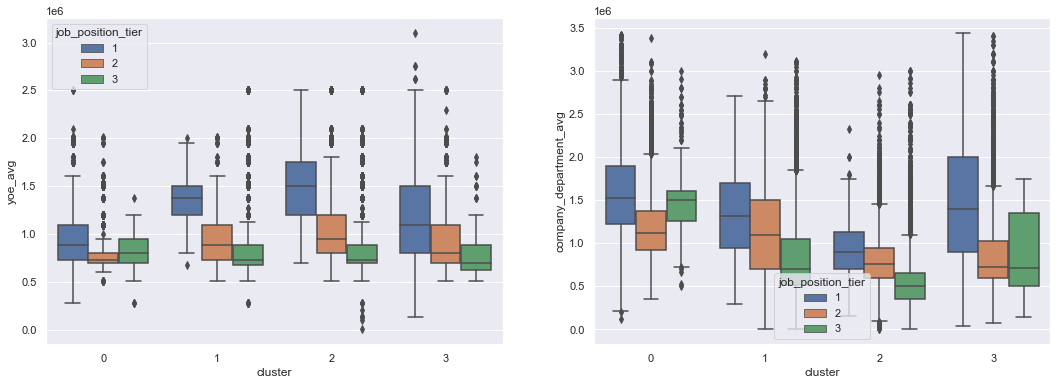

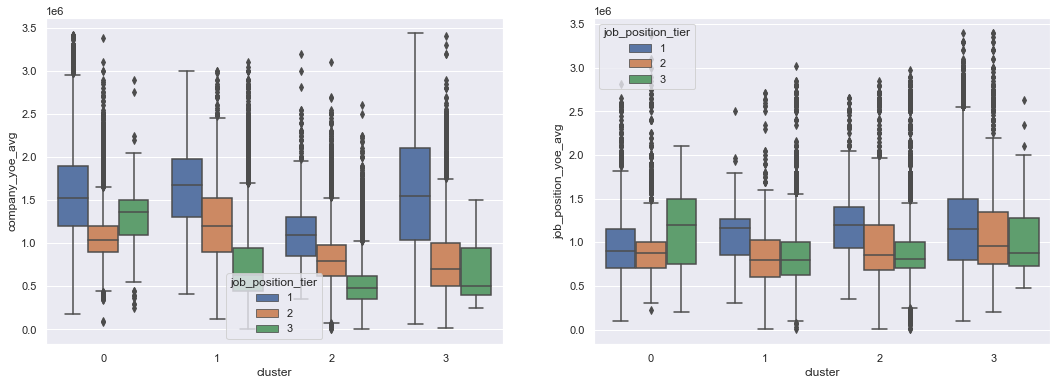

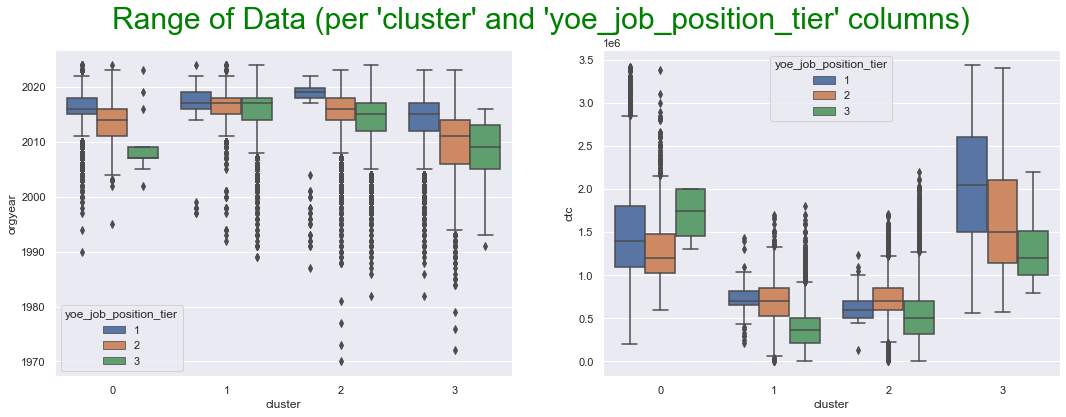

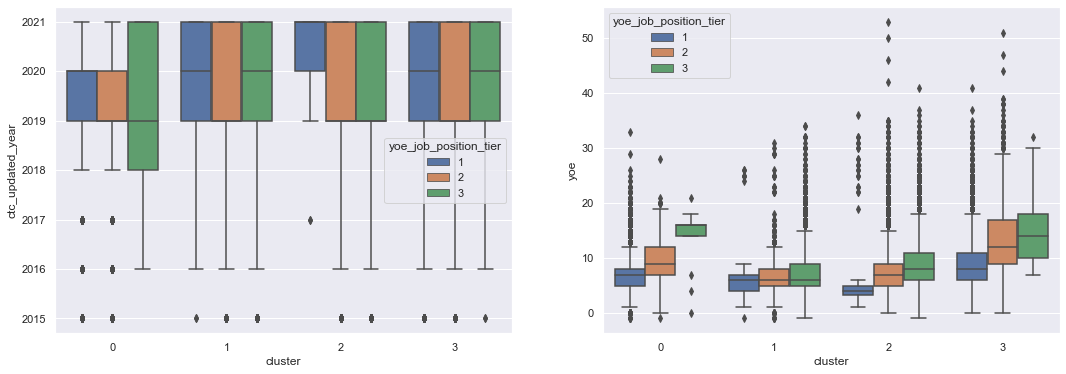

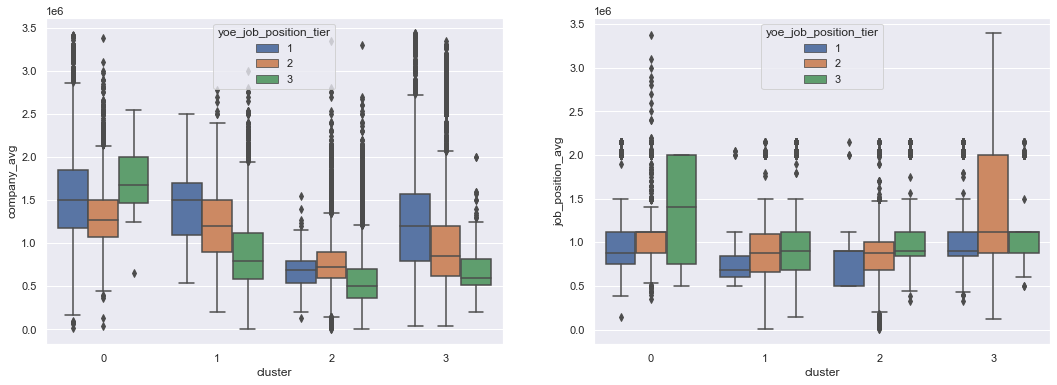

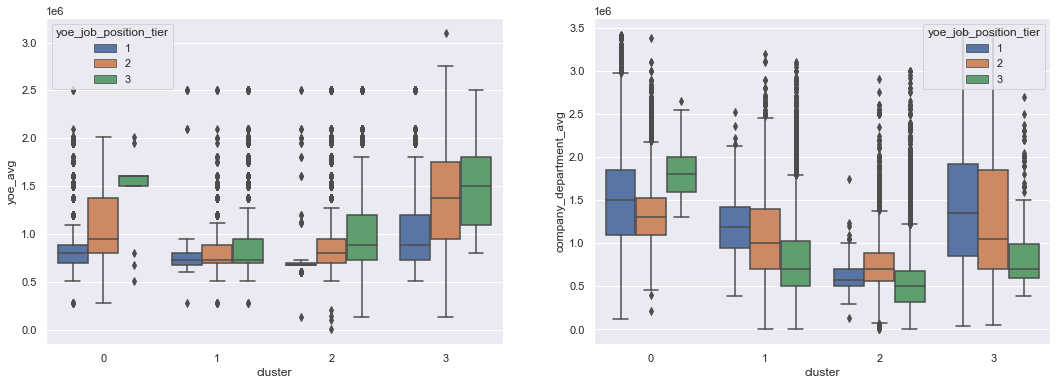

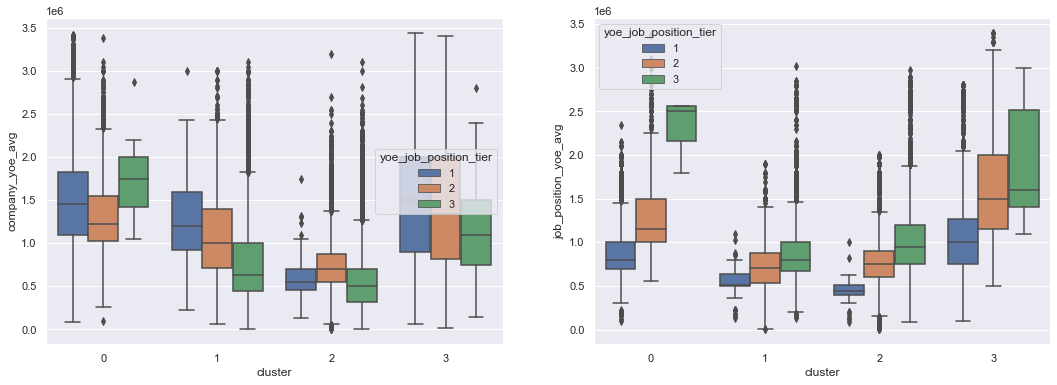

In [66]:
for category in ['cluster']:
    for hue in get_columns_by_types(df, categorical_types):
        if hue=='cluster':
            continue
        column_index = 0
        while column_index < len(get_columns_by_types(df, numeric_types)):
            fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
            if  column_index == 0:
                fig.suptitle(f"Range of Data (per '{category}' and '{hue}' columns)", fontsize=30, color="green")
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category, hue=hue)
            column_index += 1
            if column_index < len(get_columns_by_types(df, numeric_types)):
                sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category, hue=hue)
                column_index += 1
            plt.show()

***
***
## **17. Hierarchical Clustering on Sample Data.**

In [67]:
sample_training_data = training_data.sample(10000)
sample_df = df.loc[sample_training_data.index].copy()

In [68]:
model = AgglomerativeClustering(n_clusters=4)
model.fit(sample_training_data)

AgglomerativeClustering(n_clusters=4)

In [69]:
sample_df['cluster'] = model.labels_
sample_df = convert_to_best_type(df)

***
***
## **18. Analyzing Clusters - Biivariate.**

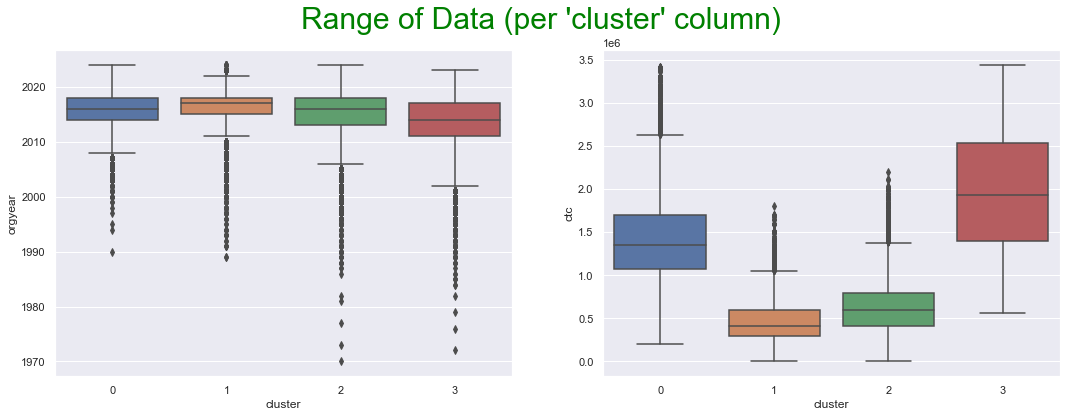

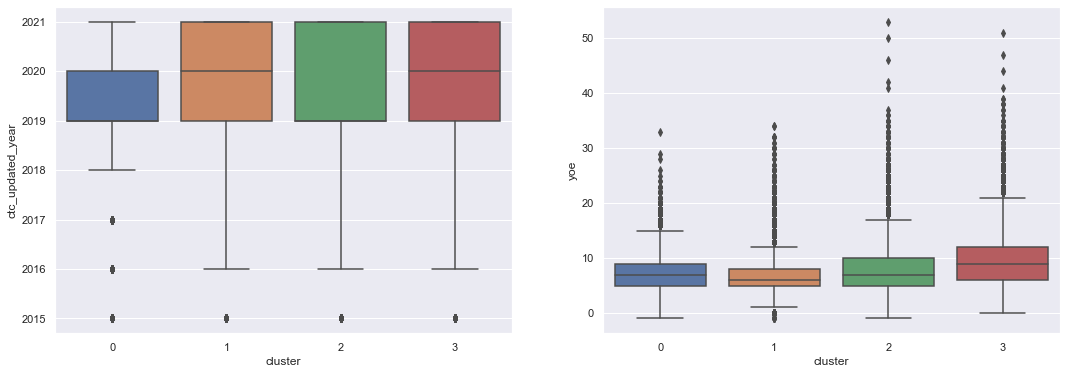

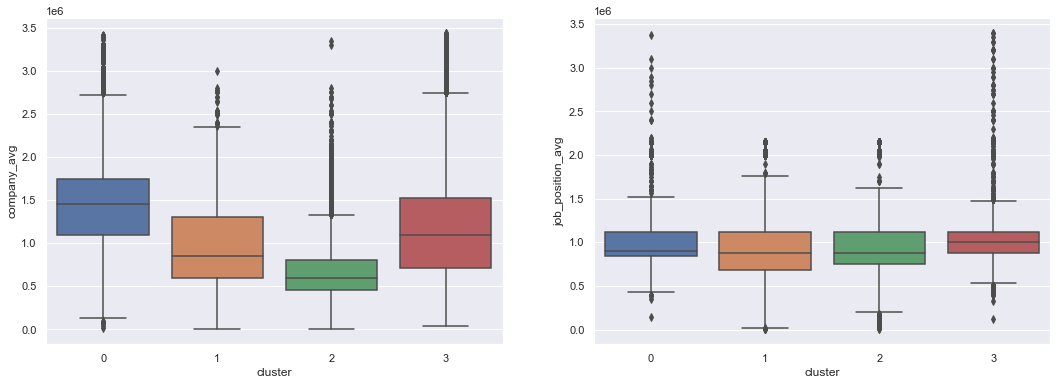

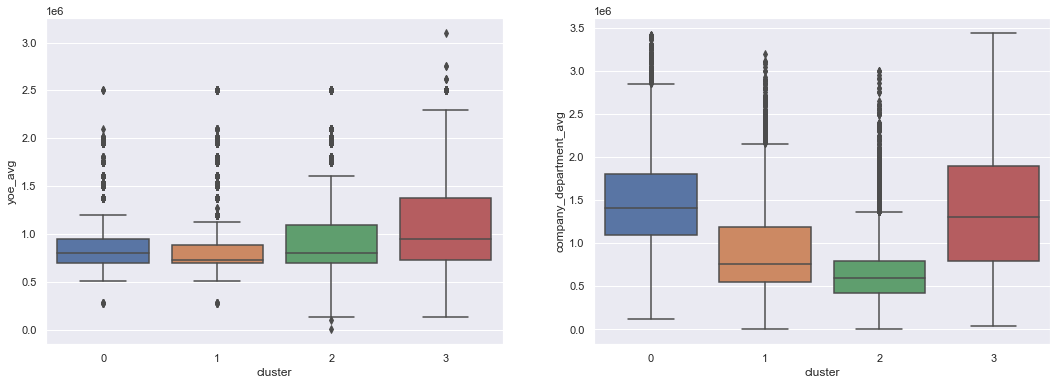

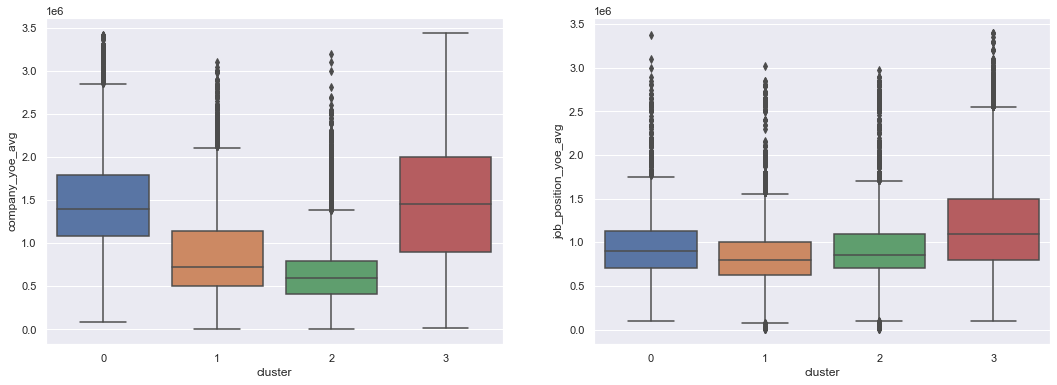

In [70]:
for category in ['cluster']:
    column_index = 0
    while column_index < len(get_columns_by_types(sample_df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(sample_df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(sample_df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(sample_df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **19. Analyzing Clusters - Multivariate.**

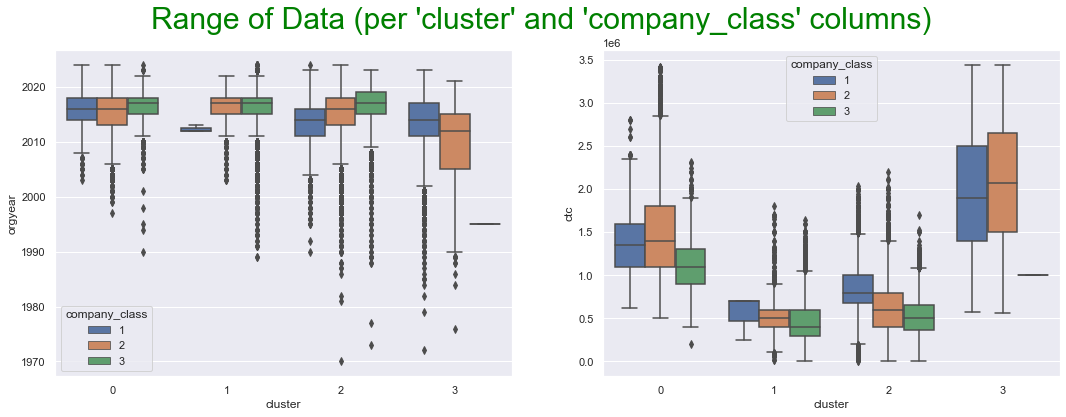

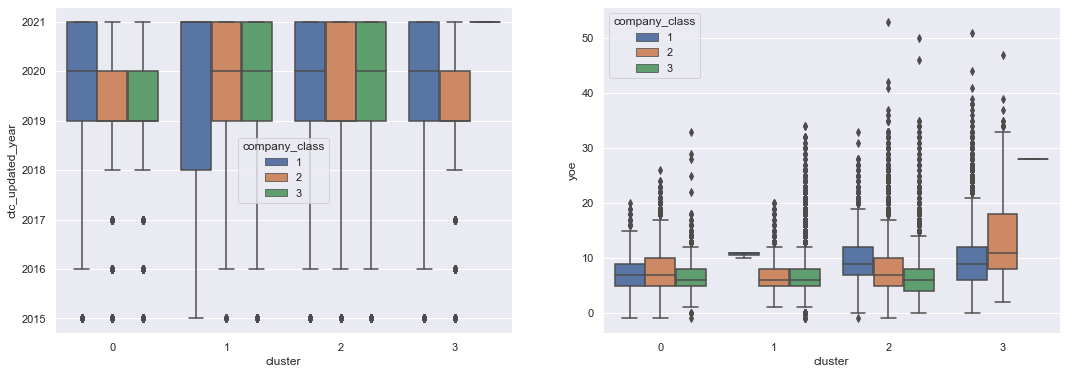

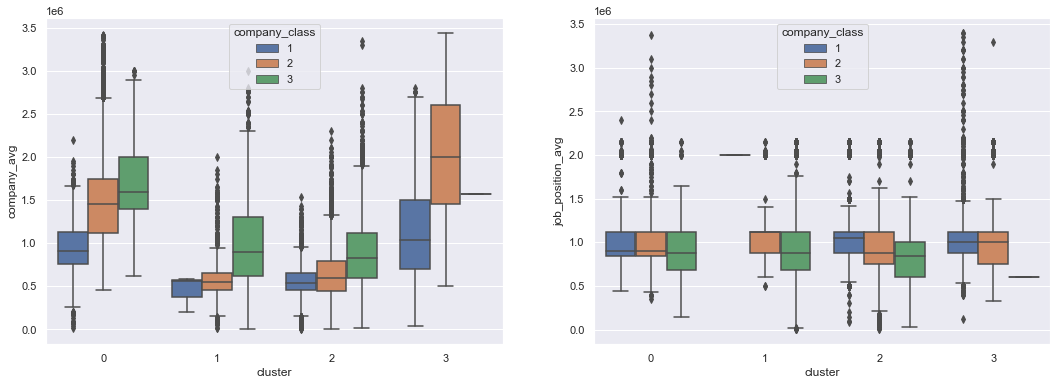

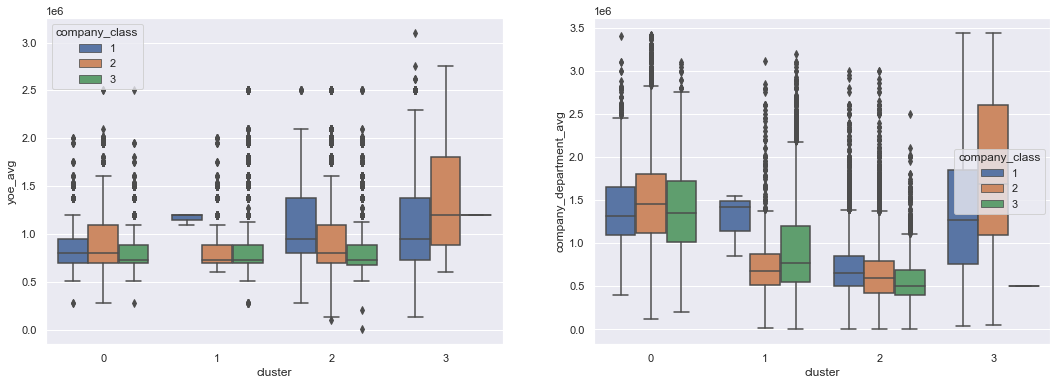

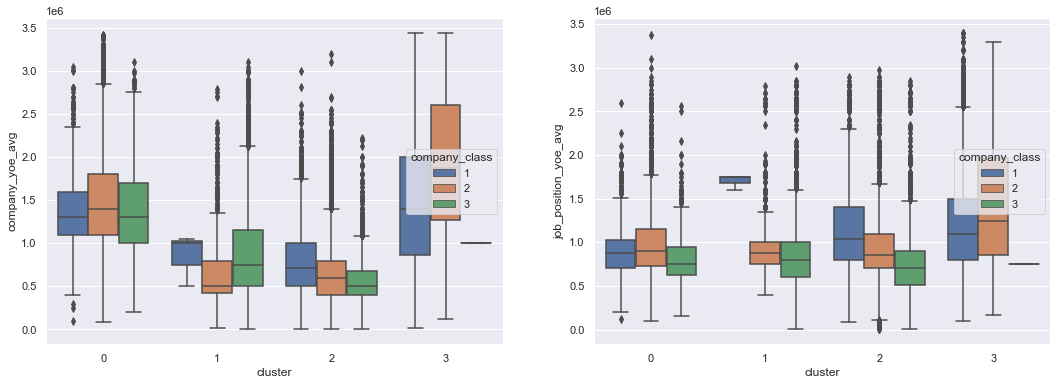

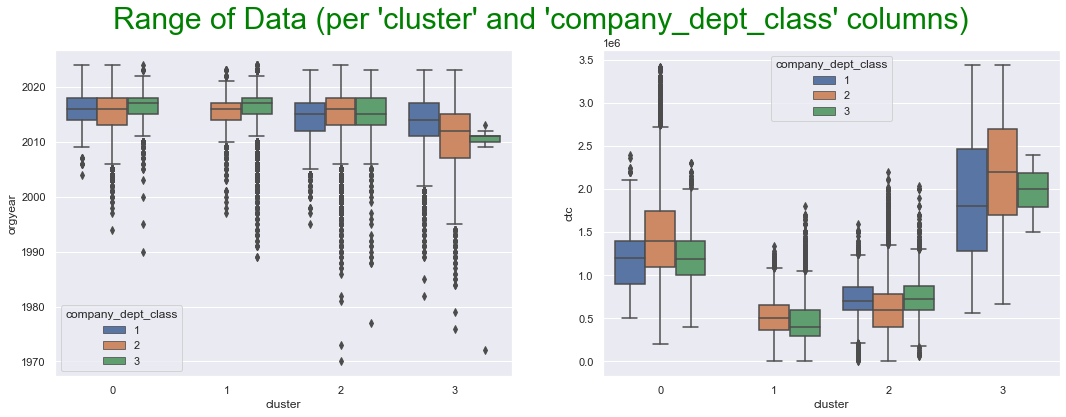

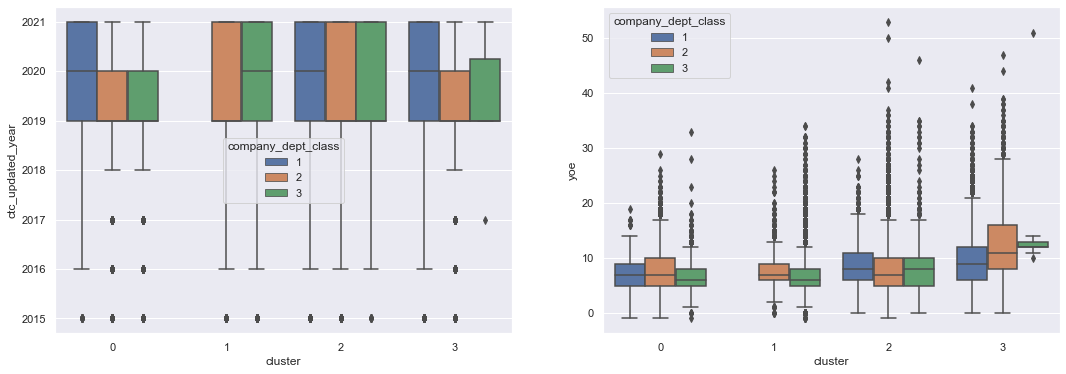

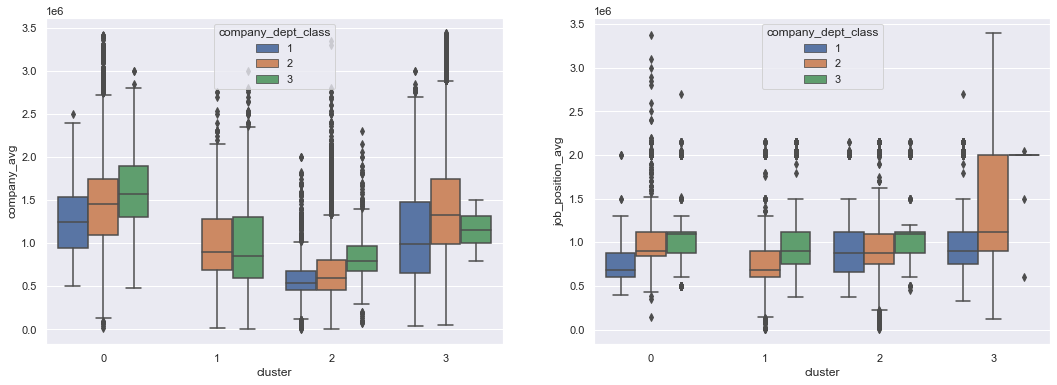

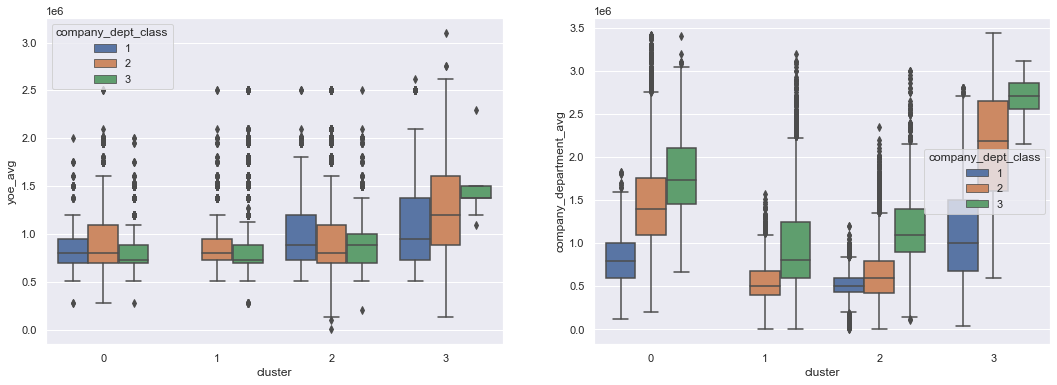

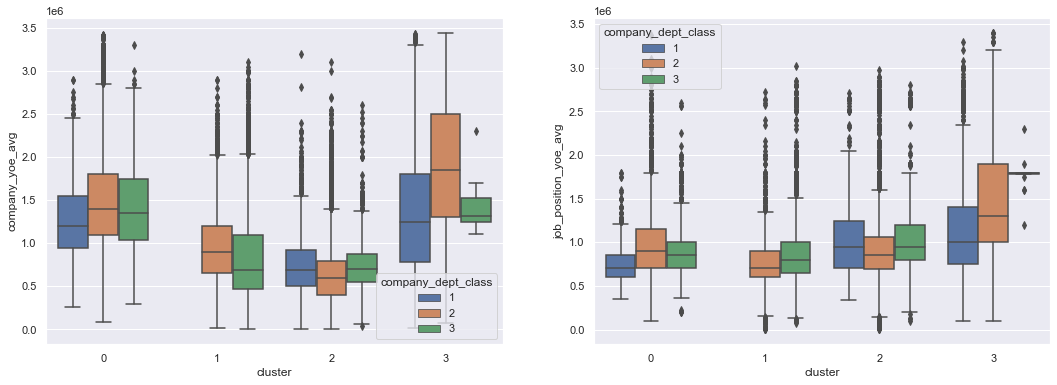

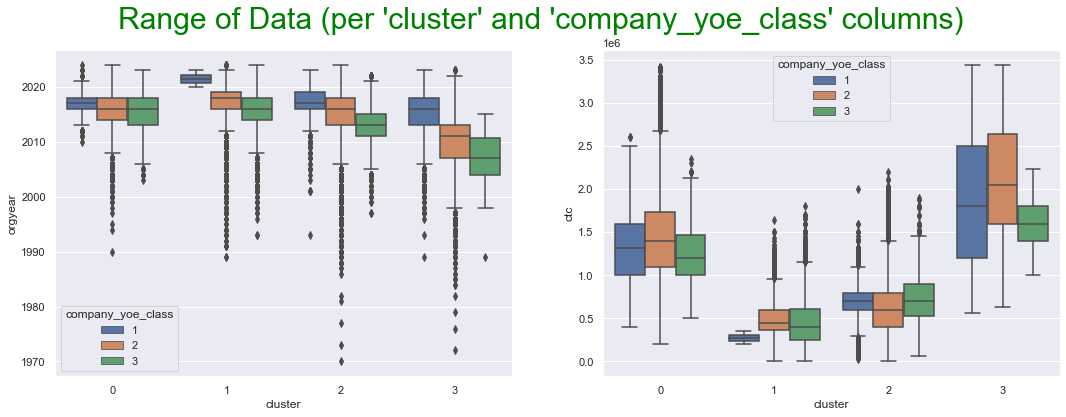

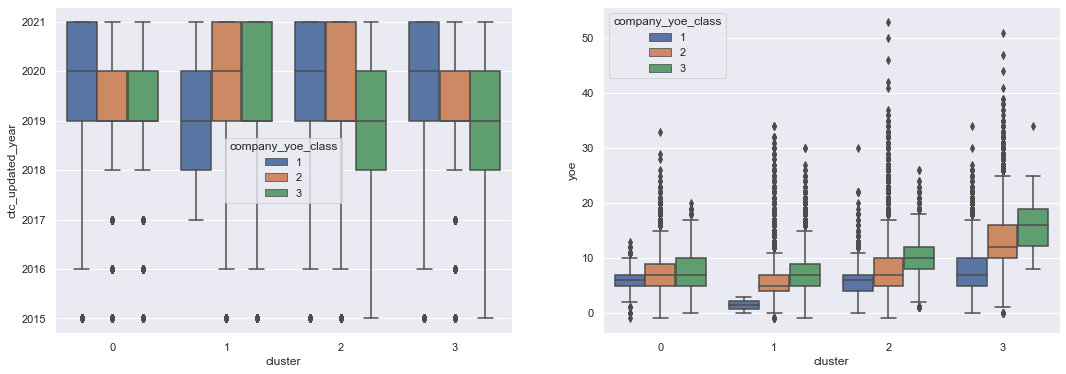

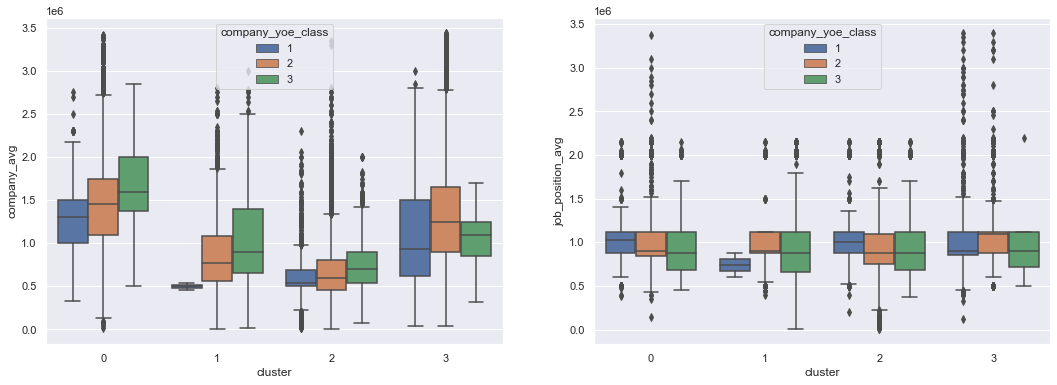

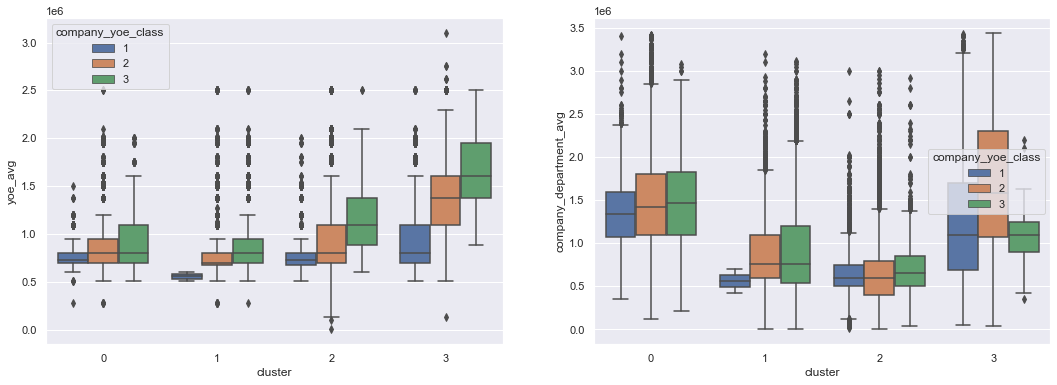

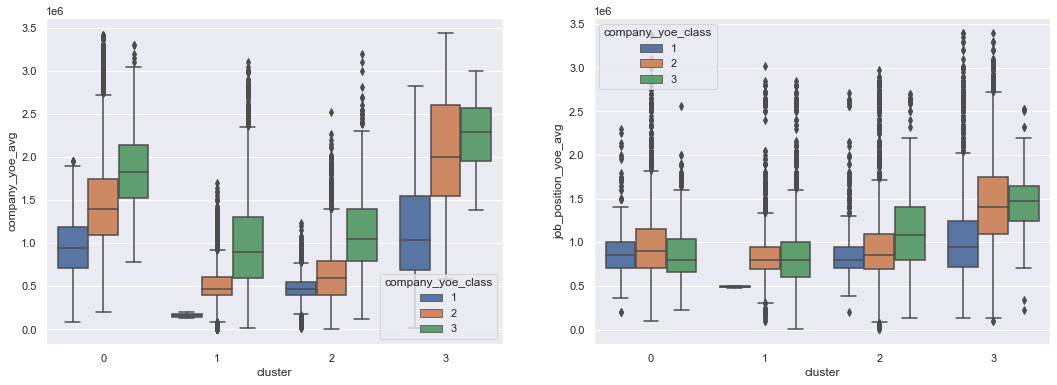

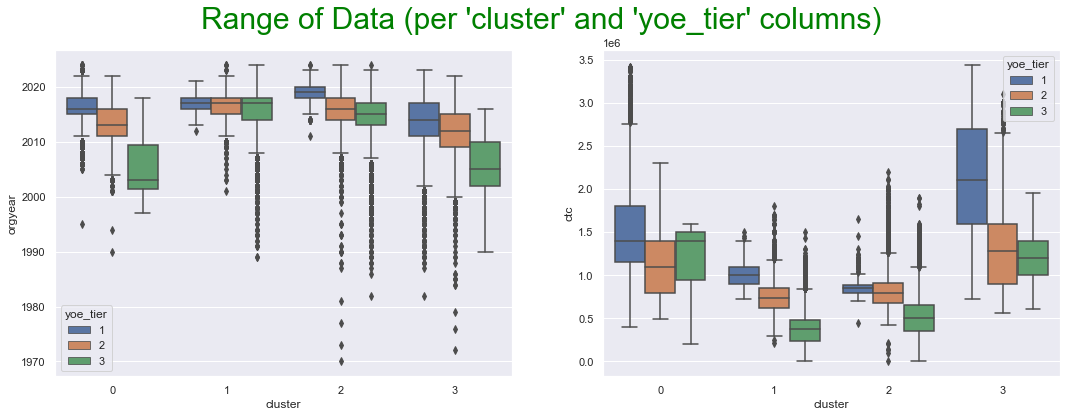

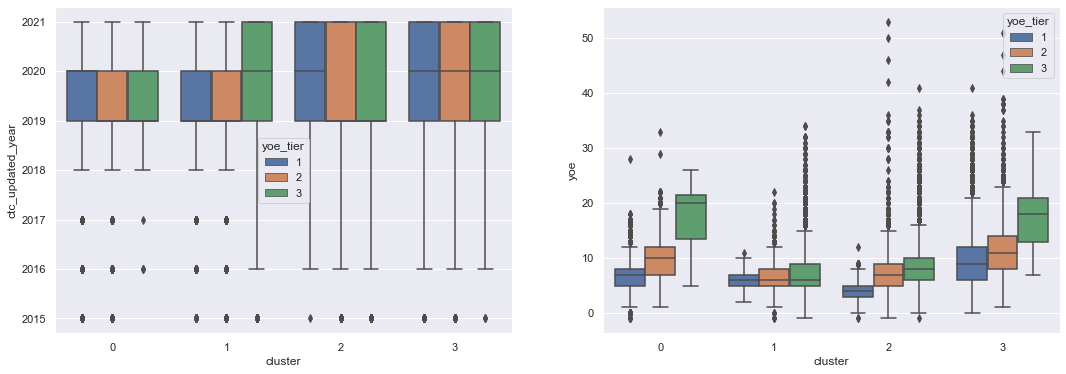

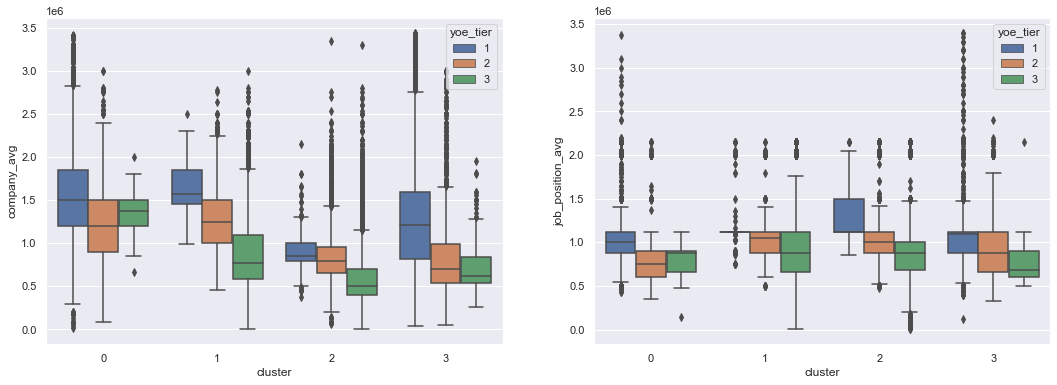

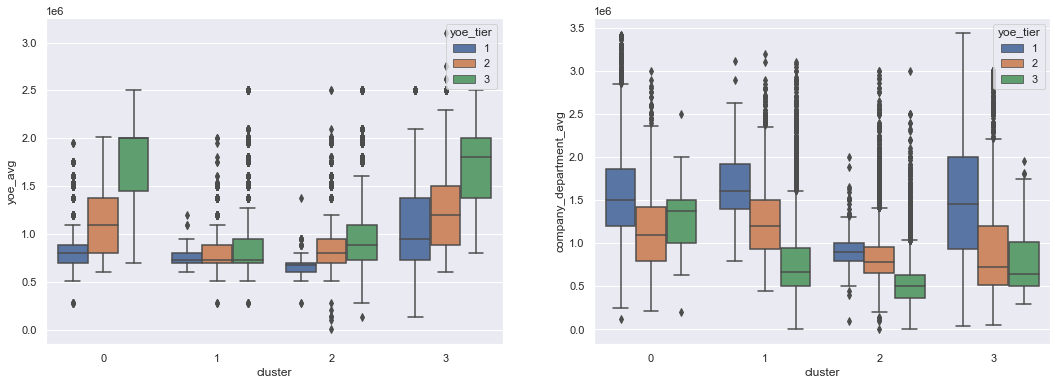

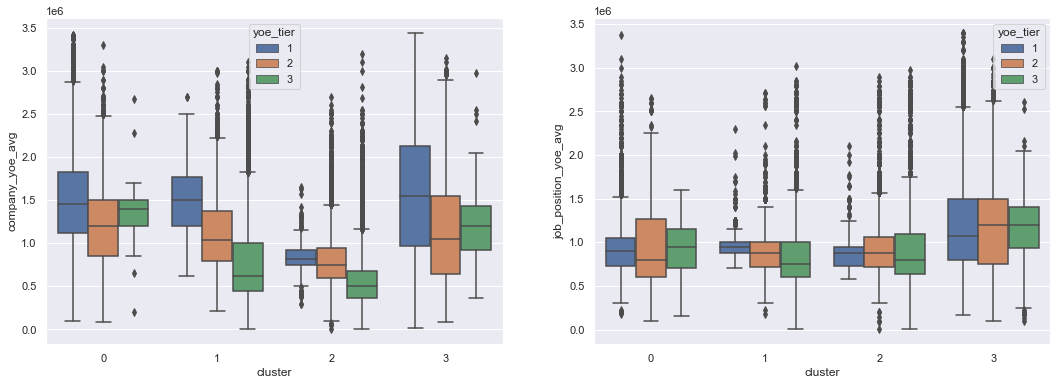

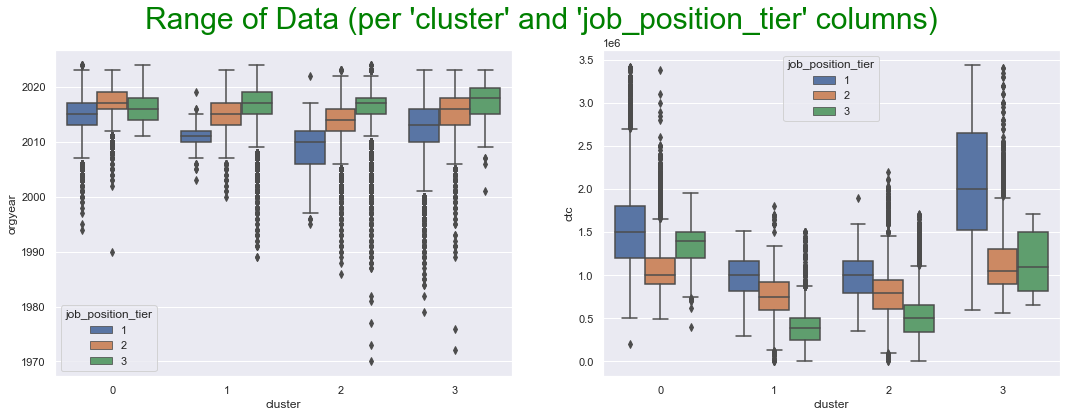

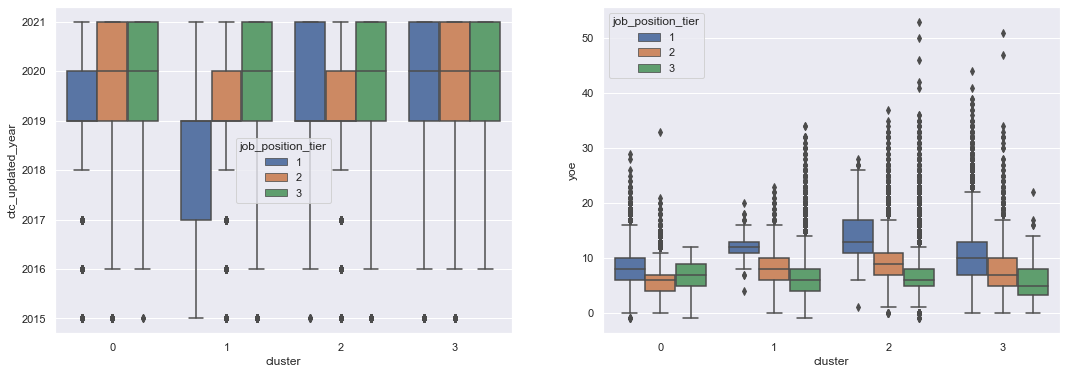

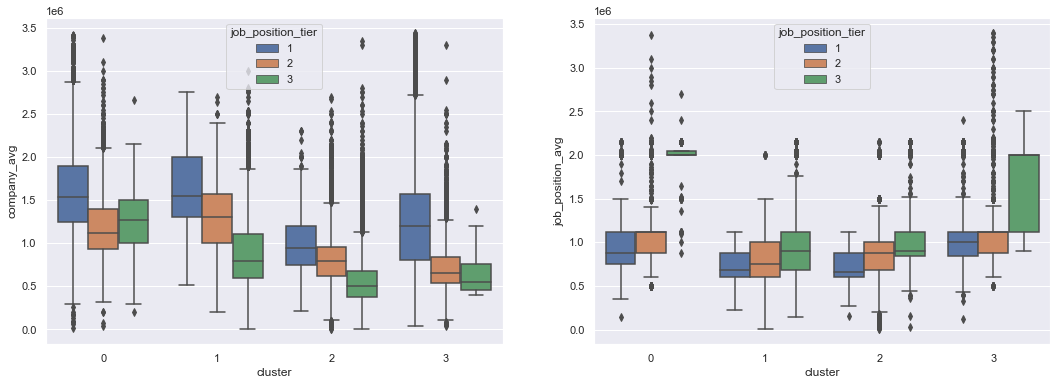

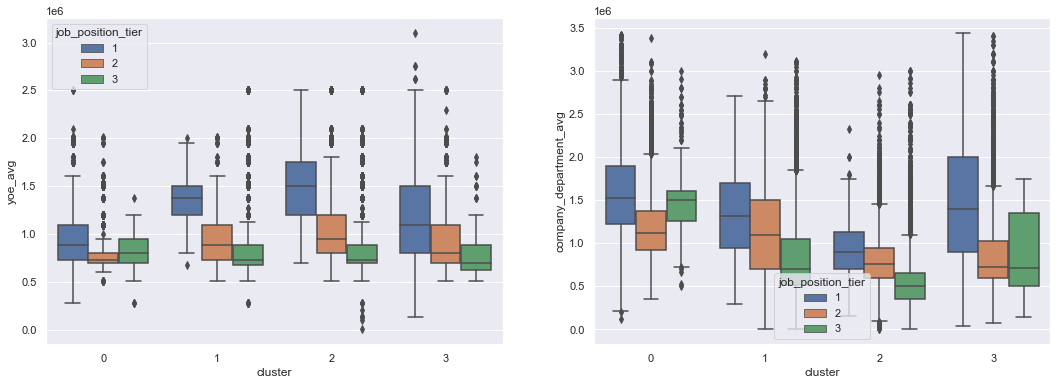

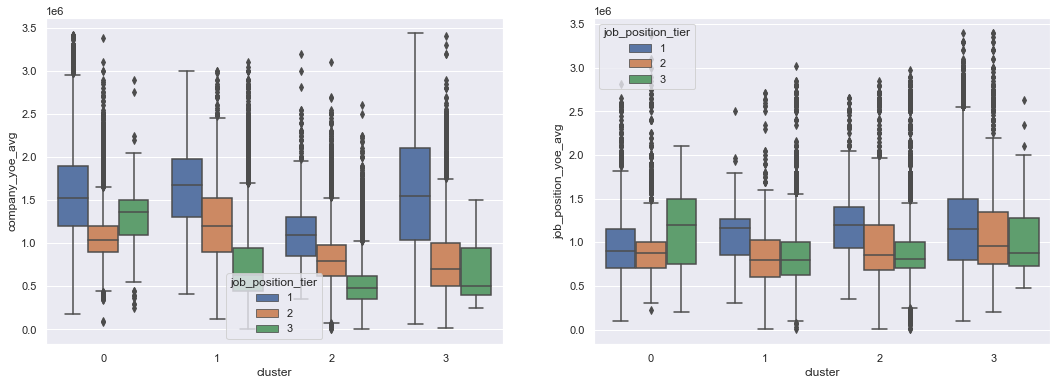

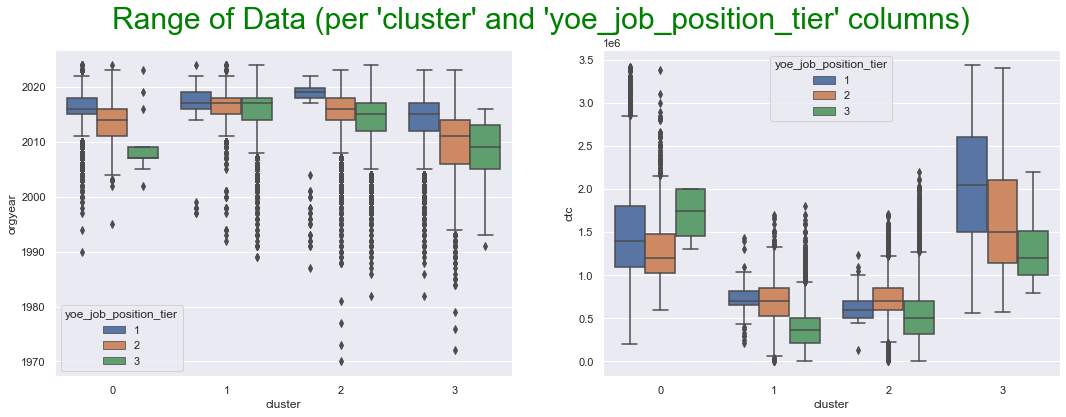

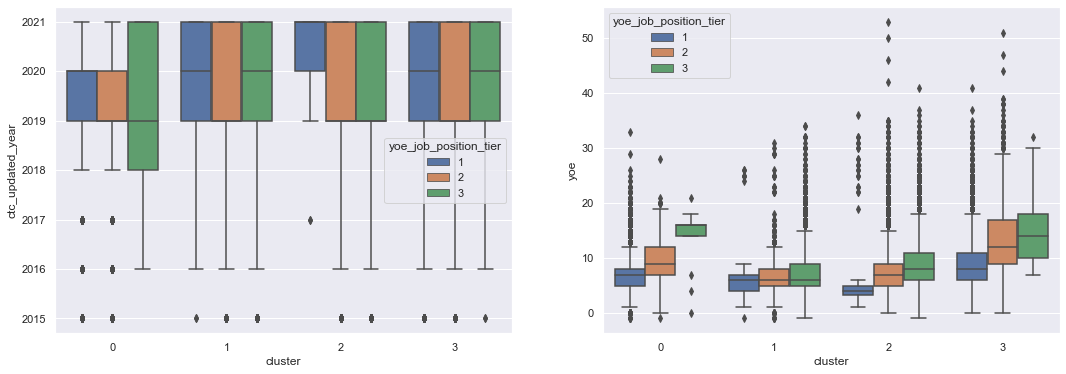

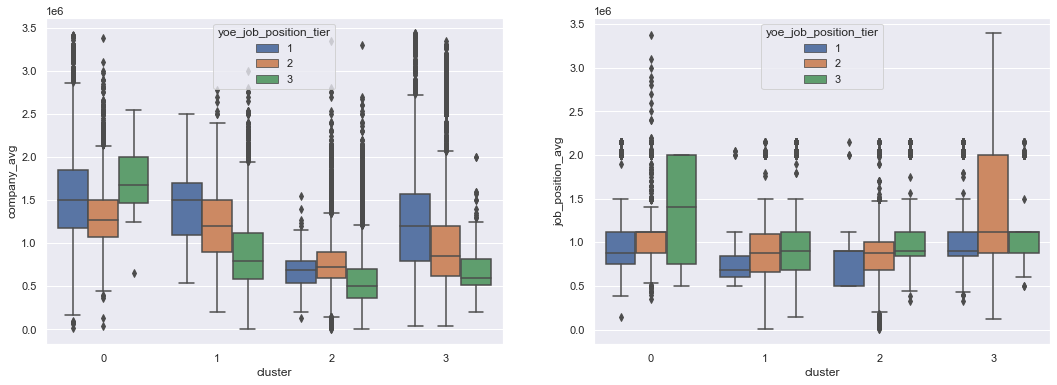

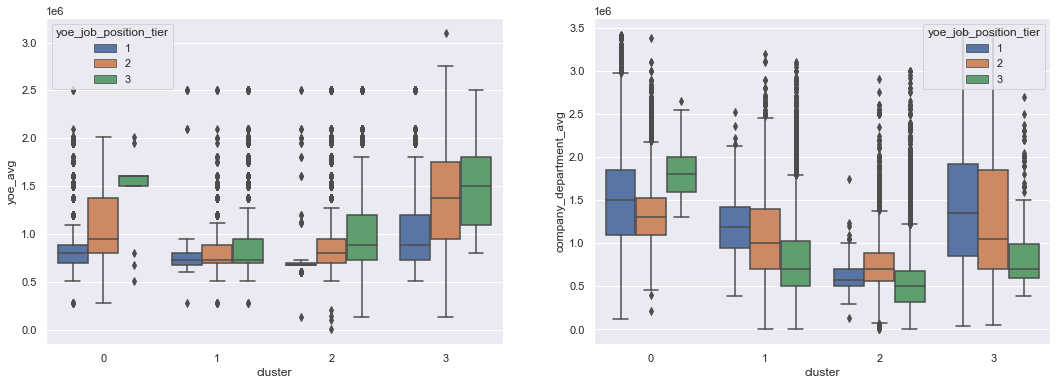

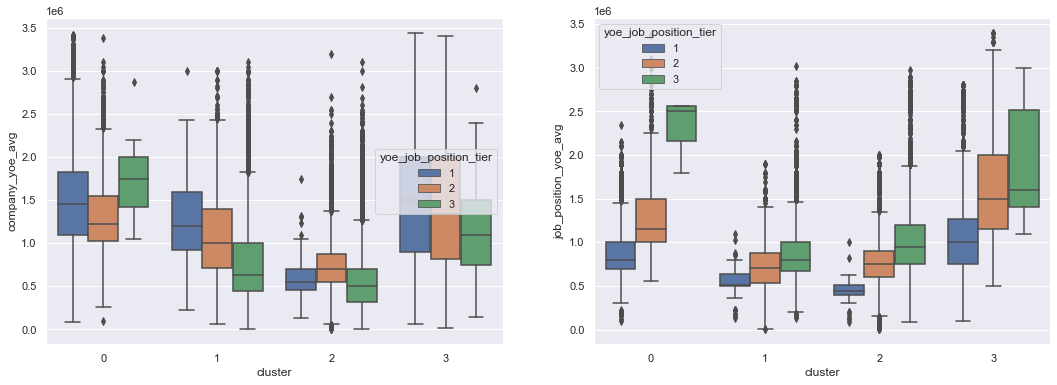

In [71]:
for category in ['cluster']:
    for hue in get_columns_by_types(sample_df, categorical_types):
        if hue=='cluster':
            continue
        column_index = 0
        while column_index < len(get_columns_by_types(sample_df, numeric_types)):
            fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
            if  column_index == 0:
                fig.suptitle(f"Range of Data (per '{category}' and '{hue}' columns)", fontsize=30, color="green")
            sns.boxplot(data=df, y=get_columns_by_types(sample_df, numeric_types)[column_index], ax=axes[0], x=category, hue=hue)
            column_index += 1
            if column_index < len(get_columns_by_types(sample_df, numeric_types)):
                sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category, hue=hue)
                column_index += 1
            plt.show()

***
***
## **20. Business Insights.**
#### **A.** Class 3 learners earn significantly less the Class 1 learners.
#### **B.** Tier 1 learners earn significantly more than tier 3 learners.
#### **C.** Experience has no direct impact on the Tier or class of a learner.
#### **D.** Most common job profiles are same irrespective of the tier or class of a learner.
#### **E.** Top 10 most common job profiles are as follows.
##### ---- 1. Backend Engineer
##### ---- 2. FullStack Engineer
##### ---- 3. Other
##### ---- 4. Frontend Engineer
##### ---- 5. Data Scientist
##### ---- 6. QA Engineer
##### ---- 7. Support Engineer
##### ---- 8. Devops Engineer
##### ---- 9. Engineering Leadership
##### ---- 10. Data Analyst
#### **F.** From the elbow method we can deduce that the optimal number of clusters can be 4.
#### **G.** Learners in the Cluster 4 have highest CTCs followed by Cluster 1 learners, Cluster 3 learners and cluster 2 learners.
#### **H.** Learners in the Cluster 1 work in companies with highest median salaries, followed by Cluster 4 learners, Cluster 2 learners and cluster 3 learners.

***
***
## **21. Recommendations.**
#### **A.** Scaler can target tier 2 or 3 learners in cluster 2 and 3, since they are earning less than the market.
#### **B.** Scaler can target class 2 or 3 learners in cluster 3, since they are earning less than the market.
#### **C.** Since tier/class 1 or 2 learners in cluster 1 and 4 already belong to top companies and already earn very high compared to market, scaler can focus on their transition into a better role in the same organization.